# **Regression Problem**
---
## Data Science Salaries 2023 💸



### Algorithms used:
* Adaptive Boost (AdaBoost)
* Gradient Boost (GradBoost)
* Extreme Boost (XGBoost)
---
### HyperParameter Tuning tools used
* GridSearch CV
* RandomizedSearch CV
* Optuna
* HyperOpt


In [1]:
!pip install optuna
!pip install hyperopt

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as py

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,r2_score

import optuna
from hyperopt import hp,fmin,tpe,Trials,space_eval

import warnings as w
w.filterwarnings('ignore')



> **Data Loading**



In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/Raj-Narayanan-B/iNeuron/Datasets/Reg%20-%20ds_salaries.csv')

In [4]:
df.shape

(3755, 11)

In [5]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M




> **Check info of dataset**



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB




> **Check Unique values of Categorical Variables**



In [7]:
for i in df.select_dtypes(include='object').columns:
    print(i,'\n',df[i].unique(),'\n')

experience_level 
 ['SE' 'MI' 'EN' 'EX'] 

employment_type 
 ['FT' 'CT' 'FL' 'PT'] 

job_title 
 ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 'Applied Machine Learning Scientist'
 'Lead Data Scientist' 'Cloud 



> **Missing Value Check**



In [8]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64



> **Outlier Removal**



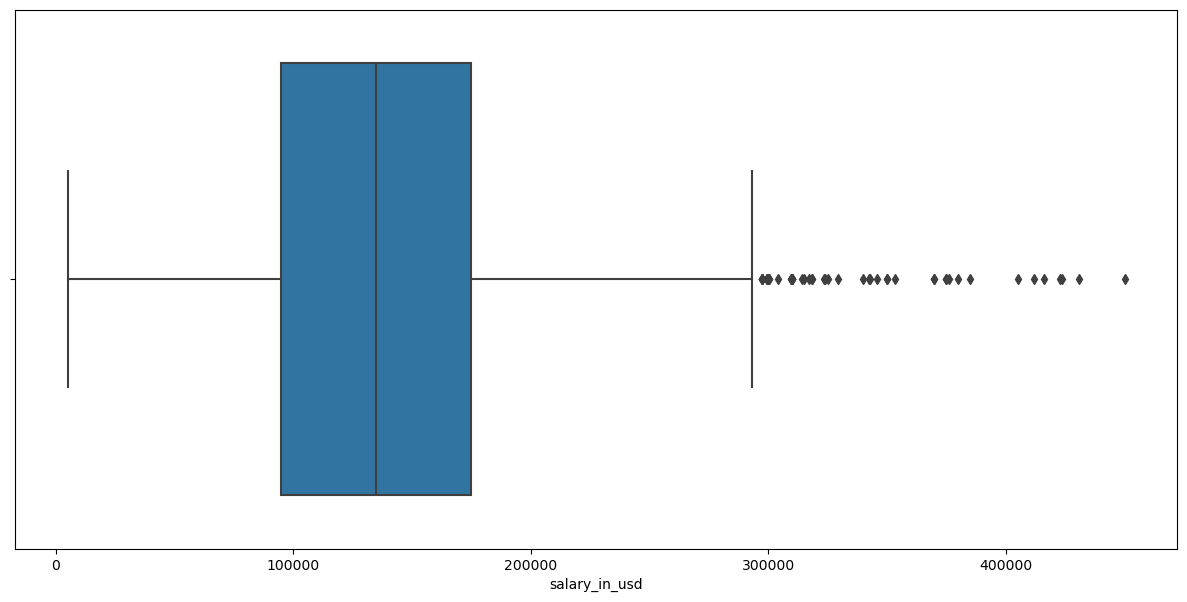

In [9]:
plt.figure(figsize=(15,7))
sns.boxplot(x=df['salary_in_usd'],hue=df['company_size'])
plt.show()

In [10]:
#OUTLIER DETECTION

q1=np.quantile(df['salary_in_usd'],0.25)
q3=np.quantile(df['salary_in_usd'],0.75)
IQR=q3-q1

low_range=q1-(1.5*IQR)
high_range=q3+(1.5*IQR)

indices=df.index[(df['salary_in_usd'] < low_range) | (df['salary_in_usd'] > high_range)]

df.drop(index=indices,inplace=True)
df.reset_index(drop=True,inplace=True)

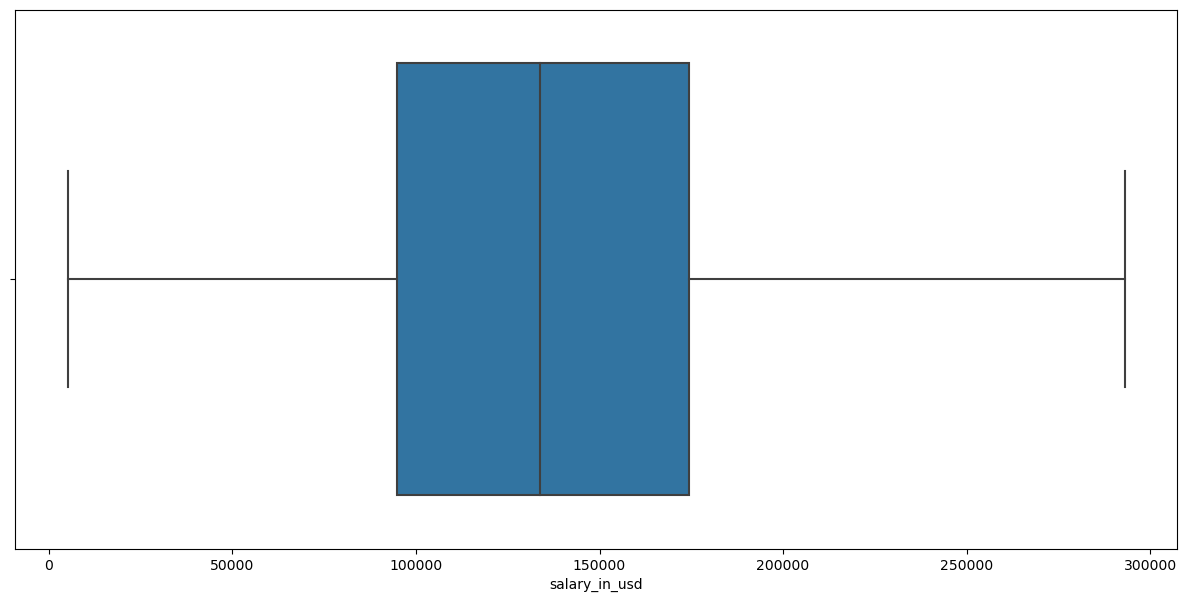

In [11]:
plt.figure(figsize=(15,7))
sns.boxplot(x=df['salary_in_usd'])
plt.show()



> **Check distribution for Target Variable**



<Axes: xlabel='salary_in_usd', ylabel='Count'>

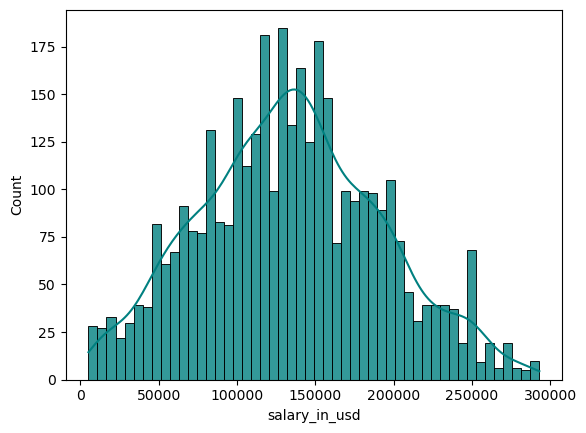

In [12]:
sns.histplot(df['salary_in_usd'],alpha=0.8,color = "teal",bins=50,kde = True)



> **Drop Unneccesary columns**



In [13]:
df.drop(columns=['salary','salary_currency','work_year'],inplace=True)



> **Rename column-remote_ratio's values into categorical variables**



In [14]:
df['remote_ratio'] = df['remote_ratio'].replace({100: 'On-site', 0:'Remote', 50:'Hybrid'})



> **Get Categorical & Numerical variables**



In [15]:
cat_cols=df.select_dtypes(include=['object']).columns

In [16]:
num_cols=df.select_dtypes(include=['number']).columns



> **Categorical Encoding via OHE**



In [17]:
df.head()

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,SE,FT,Principal Data Scientist,85847,ES,On-site,ES,L
1,MI,CT,ML Engineer,30000,US,On-site,US,S
2,MI,CT,ML Engineer,25500,US,On-site,US,S
3,SE,FT,Data Scientist,175000,CA,On-site,CA,M
4,SE,FT,Data Scientist,120000,CA,On-site,CA,M


In [18]:
for i in cat_cols:
    ohe=OneHotEncoder(dtype='int')
    array1=ohe.fit_transform(df[[i]])
    df[ohe.get_feature_names_out()]=array1.toarray()

In [19]:
df.drop(columns=list(cat_cols),inplace=True)

In [20]:
df.head()

,salary_in_usd,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_title_3D Computer Vision Researcher,...,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_L,company_size_M,company_size_S
0,85847,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,30000,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,25500,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,175000,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,120000,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0




> **Separate features and target variables**



In [21]:
x=df.drop(columns='salary_in_usd')

In [22]:
y=df['salary_in_usd']



> **Dimensionality Reduction**



In [23]:
pca=PCA()
pca.fit_transform(x)
pd.Series(np.cumsum(pca.explained_variance_ratio_)<=0.93).value_counts()

False    219
True      36
dtype: int64

In [24]:
pca1=PCA(n_components=36)
pc_components=pca1.fit_transform(x)
x_pca = pd.DataFrame(data=pc_components)
x_pca.columns = ['PC' + str(col+1) for col in x_pca.columns.values]

In [25]:
x_pca.shape

(3692, 36)

In [26]:
x_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,1.283764,-0.254543,0.787575,0.913713,0.204895,0.324967,-0.422071,-0.279883,-0.267465,-0.612735,...,-0.020545,0.005996,-0.035293,0.036544,-0.018050,-0.004045,-0.045150,-0.039559,0.018688,0.080465
1,1.047288,-0.204756,-0.477142,-0.572247,0.615308,-0.205133,-0.289030,0.270175,-0.298621,-0.219002,...,0.252426,-0.271961,0.042966,-0.151440,0.108607,-0.006413,0.133554,-0.174855,0.060875,-0.097366
2,1.047288,-0.204756,-0.477142,-0.572247,0.615308,-0.205133,-0.289030,0.270175,-0.298621,-0.219002,...,0.252426,-0.271961,0.042966,-0.151440,0.108607,-0.006413,0.133554,-0.174855,0.060875,-0.097366
3,0.860504,-0.435730,0.948944,0.295153,-1.033655,-0.127442,0.102434,-0.214739,-0.483357,-0.314049,...,-0.002874,0.013652,-0.006546,0.003709,-0.003836,-0.009167,0.007599,-0.003131,0.011061,-0.024221
4,0.860504,-0.435730,0.948944,0.295153,-1.033655,-0.127442,0.102434,-0.214739,-0.483357,-0.314049,...,-0.002874,0.013652,-0.006546,0.003709,-0.003836,-0.009167,0.007599,-0.003131,0.011061,-0.024221




> **Perform Train-Test-Split on X & y**



In [27]:
x_train,x_test,y_train,y_test=train_test_split(x_pca,y,random_state=42,train_size=0.75)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2769, 36)
(923, 36)
(2769,)
(923,)


### **GridSearchCV**




> **Initialize the base classifiers for GridSearchCV**





In [115]:
base_randf=RandomForestRegressor()
base_adab=AdaBoostRegressor()
base_gradb=GradientBoostingRegressor()
base_xgb=XGBRegressor()

#### **1. RandomForest**

In [117]:
param={'n_estimators'  :[400,650,950],
      'criterion'      :['squared_error', 'absolute_error', 'friedman_mse','poisson'],
      'max_features'   :['sqrt', 'log2', None]
      }
gsv_randf=GridSearchCV(estimator=base_randf,
                      param_grid=param,
                      n_jobs=-1,
                      scoring='r2',
                      cv=5,
                      verbose=2)

gsv_randf.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [400, 650, 950]},
             scoring='r2', verbose=2)

In [118]:
print(gsv_randf.best_score_)
print(gsv_randf.best_params_)

0.44833050537142694
{'criterion': 'poisson', 'max_features': 'sqrt', 'n_estimators': 650}


In [119]:
randf=RandomForestRegressorrestRegressor(**gsv_randf.best_params_)
randf.fit(x_train,y_train)
y_pred=randf.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

42.35 %


#### **2. AdaBoost**

In [30]:
param={
    'n_estimators'  :[400,650,950],
    'learning_rate' :list(np.linspace(0.001,1,50)),
    'loss'          :['linear', 'square', 'exponential']
}

gsv_adab=GridSearchCV(estimator=base_adab,
                 param_grid=param,
                 n_jobs=-1,
                 scoring='r2',
                 cv=5,
                 verbose=2)

gsv_adab.fit(x_train,y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.021387755102040818,
                                           0.041775510204081635,
                                           0.062163265306122456,
                                           0.08255102040816327,
                                           0.10293877551020408,
                                           0.12332653061224491,
                                           0.1437142857142857,
                                           0.16410204081632654,
                                           0.18448979591836737,
                                           0.20487755102040817,
                                           0.225265306122449,
                                           0.24565306122448982,
                                           0.266040816326530...
                                           0.3272040816326531,
                                           0.3475918367346939,
                                           0.36797959183673473,
                                           0.3883673469387755,
                                           0.40875510204081633,
                                           0.42914285714285716,
                                           0.449530612244898,
                                           0.4699183673469388,
                                           0.49030612244897964,
                                           0.5106938775510205,
                                           0.5310816326530613,
                                           0.551469387755102,
                                           0.5718571428571428,
                                           0.5922448979591837, ...],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [400, 650, 950]},
             scoring='r2', verbose=2)

In [31]:
print(gsv_adab.best_score_)
print(gsv_adab.best_params_)

0.3930481175770927
{'learning_rate': 0.021387755102040818, 'loss': 'exponential', 'n_estimators': 400}


In [32]:
adab=AdaBoostRegressor(**gsv_adab.best_params_)
adab.fit(x_train,y_train)
y_pred=adab.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

35.24 %


In [33]:
np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred))

48031.5733126703

#### Checked performance using only correlated features to target via Linear Regression and then Adaboost

corr=(df.corr()[['salary_in_usd']]>0.1) | (df.corr()[['salary_in_usd']]<-0.1)

df_corr=df.corr()[['salary_in_usd']][corr]

df_corr.dropna(inplace=True)

plt.figure(figsize=(2,15))
sns.heatmap(df_corr,annot=True)
plt.show()

list(df_corr.index)

df_corr.dropna(inplace=True)

df_new=df[list(df_corr.index)].copy()

x_new=df_new.drop(columns='salary_in_usd')
y_new=df_new['salary_in_usd']

x_new_train,x_new_test,y_new_train,y_new_test=train_test_split(x_new,y_new,train_size=0.75,random_state=5)

from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_new_train,y_new_train)
y_new_pred=lr.predict(x_new_test)
print(r2_score(y_true=y_new_test,y_pred=y_new_pred))
print(np.sqrt(mean_squared_error(y_true=y_new_test,y_pred=y_new_pred)))

adab=AdaBoostRegressor(learning_rate=0.021387755102040818, 
                       loss='linear',
                       n_estimators=400)
adab.fit(x_new_train,y_new_train)
y_pred_adab=adab.predict(x_new_test)
print(r2_score(y_new_test,y_pred_adab,))

#### **3. GradBoost**

In [34]:
param={
    'n_estimators'  :[400,650,950],
    'learning_rate' :list(np.linspace(0.001,1,5)),
    'max_depth'     :list(range(4,13)),
    'loss'          :['squared_error', 'absolute_error', 'huber', 'quantile']
}

gsv_gb=GridSearchCV(estimator=base_gradb,
                 param_grid=param,
                 n_jobs=-1,
                 scoring='r2',
                 cv=5,
                 verbose=2)

gsv_gb.fit(x_train,y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.25075, 0.5005, 0.75025,
                                           1.0],
                         'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [400, 650, 950]},
             scoring='r2', verbose=2)

In [40]:
print(gsv_gb.best_score_)
print(gsv_gb.best_params_)

0.4371264542015195
{'learning_rate': 0.25075, 'loss': 'absolute_error', 'max_depth': 5, 'n_estimators': 400}


In [81]:
gradb=GradientBoostingRegressor(**gsv_gb.best_params_)
gradb.fit(x_train,y_train)
y_pred=gradb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

41.34 %


#### **4. XGBoost**

In [41]:
param = {
    'n_estimators'      : [400,500,600,900,1000],
    'max_depth'         : [8,9,10],
    'learning_rate'     : list(np.linspace(0.01,1,50)),
    #'tree_method'       : ['gpu_hist']
}

gsv_xgb=GridSearchCV(estimator=base_xgb,
                     param_grid=param,
                     n_jobs=-1,
                     cv=5,
                     scoring='r2',
                     verbose=2)
gsv_xgb.fit(x_train,y_train)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                           0.333265306122449,
                                           0.35346938775510206,
                                           0.3736734693877551,
                                           0.39387755102040817,
                                           0.4140816326530612,
                                           0.4342857142857143,
                                           0.45448979591836736,
                                           0.4746938775510204,
                                           0.49489795918367346,
                                           0.5151020408163265,
                                           0.5353061224489796,
                                           0.5555102040816327,
                                           0.5757142857142857,
                                           0.5959183673469388, ...],
                         'max_depth': [8, 9, 10],
                         'n_estimators': [400, 500, 600, 900, 1000]},
             scoring='r2', verbose=2)

In [42]:
print(gsv_xgb.best_score_)
print(gsv_xgb.best_params_)

0.4335705718786077
{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 400}


In [82]:
xgb=XGBRegressor(**gsv_xgb.best_params_)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

41.08 %


### **RandomizedSearchCV**




> **Initialize the base classifiers for RandomizedSearchCV**





In [120]:
base_randf=RandomForestRegressor()
base_adab=AdaBoostRegressor()
base_gradb=GradientBoostingRegressor()
base_xgb=XGBRegressor()

#### **1. RandomForest**

In [121]:
param={'n_estimators'  :[400,650,950],
      'criterion'      :['squared_error', 'absolute_error', 'friedman_mse','poisson'],
      'max_features'   :['sqrt', 'log2', None]
      }
gsv_randf=RandomizedSearchCV(
                        estimator=base_randf,
                        param_distributions=param,
                        n_iter=100,
                        n_jobs=-1,
                        scoring='r2',
                        cv=5,
                        verbose=2,
                        random_state=3)

gsv_randf.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [400, 650, 950]},
                   random_state=3, scoring='r2', verbose=2)

In [122]:
print(gsv_randf.best_score_)
print(gsv_randf.best_params_)

0.44819408590990434
{'n_estimators': 950, 'max_features': 'sqrt', 'criterion': 'poisson'}


In [123]:
randf=RandomForestRegressor(**gsv_randf.best_params_)
randf.fit(x_train,y_train)
y_pred=randf.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

42.18 %


#### **2. AdaBoost**

In [44]:
param={
    'n_estimators'  :[400,650,950,1200,1500,2000],
    'learning_rate' :list(np.linspace(0.001,1,100)),
    'loss'          :['linear', 'square', 'exponential']
}

randSCV_adab=RandomizedSearchCV(
    estimator=base_adab,
    param_distributions=param,
    n_iter=100,
    n_jobs=-1,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=3)

randSCV_adab.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001,
                                                          0.011090909090909092,
                                                          0.021181818181818184,
                                                          0.03127272727272727,
                                                          0.041363636363636366,
                                                          0.05145454545454546,
                                                          0.06154545454545455,
                                                          0.07163636363636364,
                                                          0.08172727272727273,
                                                          0.09181818181818183,
                                                          0.10190909090909092,
                                                          0.112,
                                                          0.1220909090909091,
                                                          0.1...
                                                          0.18263636363636365,
                                                          0.19272727272727275,
                                                          0.20281818181818184,
                                                          0.2129090909090909,
                                                          0.223,
                                                          0.2330909090909091,
                                                          0.2431818181818182,
                                                          0.25327272727272726,
                                                          0.26336363636363636,
                                                          0.27345454545454545,
                                                          0.28354545454545454,
                                                          0.29363636363636364, ...],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [400, 650, 950, 1200,
                                                         1500, 2000]},
                   random_state=3, scoring='r2', verbose=2)

In [45]:
print(randSCV_adab.best_score_)
print(randSCV_adab.best_params_)

0.39146557065585247
{'n_estimators': 650, 'loss': 'exponential', 'learning_rate': 0.011090909090909092}


In [83]:
adab=AdaBoostRegressor(**randSCV_adab.best_params_)
adab.fit(x_train,y_train)
y_pred=adab.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

35.42 %


#### **3. GradientBoost**

In [46]:
param={
    'n_estimators'  :[400,650,950,1200,1500,2000],
    'learning_rate' :list(np.linspace(0.001,1,100)),
    'max_depth'     :list(range(4,13)),
    'loss'          :['squared_error', 'absolute_error', 'huber', 'quantile']
}

randSCV_gb=RandomizedSearchCV(
    estimator=base_gradb,
    param_distributions =param,
    n_iter=100,
    n_jobs=-1,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=3)

randSCV_gb.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001,
                                                          0.011090909090909092,
                                                          0.021181818181818184,
                                                          0.03127272727272727,
                                                          0.041363636363636366,
                                                          0.05145454545454546,
                                                          0.06154545454545455,
                                                          0.07163636363636364,
                                                          0.08172727272727273,
                                                          0.09181818181818183,
                                                          0.10190909090909092,
                                                          0.112,
                                                          0.122090909090...
                                                          0.20281818181818184,
                                                          0.2129090909090909,
                                                          0.223,
                                                          0.2330909090909091,
                                                          0.2431818181818182,
                                                          0.25327272727272726,
                                                          0.26336363636363636,
                                                          0.27345454545454545,
                                                          0.28354545454545454,
                                                          0.29363636363636364, ...],
                                        'loss': ['squared_error',
                                                 'absolute_error', 'huber',
                                                 'quantile'],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12],
                                        'n_estimators': [400, 650, 950, 1200,
                                                         1500, 2000]},
                   random_state=3, scoring='r2', verbose=2)

In [47]:
print(randSCV_gb.best_score_)
print(randSCV_gb.best_params_)

0.43579453998208584
{'n_estimators': 400, 'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 0.10190909090909092}


In [85]:
gradb=GradientBoostingRegressor(**randSCV_gb.best_params_)
gradb.fit(x_train,y_train)
y_pred=gradb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

40.77 %


#### **4. XGBoost**

In [52]:
param = {
    'n_estimators'      : [400,500,600,900,1000],
    'max_depth'         : [8,9,10],
    'learning_rate'     : list(np.linspace(0.01,1,50)),
    #'tree_method'       : ['gpu_hist']
}

randSCV_xgb=RandomizedSearchCV(estimator=base_xgb,
    param_distributions =param,
    n_iter=100,
    n_jobs=-1,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=3)

randSCV_xgb.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                          0.35346938775510206,
                                                          0.3736734693877551,
                                                          0.39387755102040817,
                                                          0.4140816326530612,
                                                          0.4342857142857143,
                                                          0.45448979591836736,
                                                          0.4746938775510204,
                                                          0.49489795918367346,
                                                          0.5151020408163265,
                                                          0.5353061224489796,
                                                          0.5555102040816327,
                                                          0.5757142857142857,
                                                          0.5959183673469388, ...],
                                        'max_depth': [8, 9, 10],
                                        'n_estimators': [400, 500, 600, 900,
                                                         1000]},
                   random_state=3, scoring='r2', verbose=2)

In [53]:
print(randSCV_xgb.best_score_)
print(randSCV_xgb.best_params_)

0.4247866901768531
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.030204081632653063}


In [86]:
xgb=XGBRegressor(**randSCV_xgb.best_params_)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

41.04 %


### **Optuna**


#### **1. RandomForest**

In [124]:
def objective(trial):
  param={
      'n_estimators'  :trial.suggest_int('n_estimators',100,2000),
      'criterion'     :trial.suggest_categorical('criterion',['squared_error', 'absolute_error', 'friedman_mse','poisson']),
      'max_features'  :trial.suggest_categorical('max_features',['sqrt', 'log2', None])
  }


  opt_randf=RandomForestRegressor(**param)
  opt_randf.fit(x_train,y_train)
  y_pred=opt_randf.predict(x_test)
  r2=r2_score(y_test,y_pred)
  r2_scores.append(r2)
  print('max_r2_score',max(r2_scores))
  return(r2)

In [125]:
r2_scores=[]
find_params=optuna.create_study()
find_params.optimize(objective,n_trials=100,n_jobs=-1)

[I 2023-06-02 10:38:32,407] A new study created in memory with name: no-name-ca0325a2-ecef-4cc2-ba69-aed855493294
[I 2023-06-02 10:38:47,802] Trial 0 finished with value: 0.4230121099062004 and parameters: {'n_estimators': 670, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 0 with value: 0.4230121099062004.


max_r2_score 0.4230121099062004


[I 2023-06-02 10:38:53,203] Trial 3 finished with value: 0.4226529346949749 and parameters: {'n_estimators': 927, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 3 with value: 0.4226529346949749.


max_r2_score 0.4230121099062004


[I 2023-06-02 10:38:54,168] Trial 4 finished with value: 0.4239444928866928 and parameters: {'n_estimators': 952, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 3 with value: 0.4226529346949749.


max_r2_score 0.4239444928866928


[I 2023-06-02 10:38:55,346] Trial 2 finished with value: 0.4246637372844605 and parameters: {'n_estimators': 995, 'criterion': 'squared_error', 'max_features': 'sqrt'}. Best is trial 3 with value: 0.4226529346949749.


max_r2_score 0.4246637372844605


[I 2023-06-02 10:38:57,919] Trial 6 finished with value: 0.42535016059374275 and parameters: {'n_estimators': 1112, 'criterion': 'friedman_mse', 'max_features': 'sqrt'}. Best is trial 3 with value: 0.4226529346949749.


max_r2_score 0.42535016059374275


[I 2023-06-02 10:39:25,311] Trial 10 finished with value: 0.4240320096039082 and parameters: {'n_estimators': 1669, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 3 with value: 0.4226529346949749.


max_r2_score 0.42535016059374275


[I 2023-06-02 10:39:31,528] Trial 9 finished with value: 0.4225264414555845 and parameters: {'n_estimators': 521, 'criterion': 'squared_error', 'max_features': None}. Best is trial 9 with value: 0.4225264414555845.


max_r2_score 0.42535016059374275


[I 2023-06-02 10:39:38,452] Trial 11 finished with value: 0.4227181325970142 and parameters: {'n_estimators': 571, 'criterion': 'friedman_mse', 'max_features': None}. Best is trial 9 with value: 0.4225264414555845.


max_r2_score 0.42535016059374275


[I 2023-06-02 10:39:48,356] Trial 14 finished with value: 0.42592686819145775 and parameters: {'n_estimators': 995, 'criterion': 'friedman_mse', 'max_features': 'sqrt'}. Best is trial 9 with value: 0.4225264414555845.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:07,016] Trial 15 finished with value: 0.423312591214837 and parameters: {'n_estimators': 1407, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 9 with value: 0.4225264414555845.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:11,018] Trial 1 finished with value: 0.4212704667679925 and parameters: {'n_estimators': 1041, 'criterion': 'poisson', 'max_features': None}. Best is trial 1 with value: 0.4212704667679925.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:13,879] Trial 12 finished with value: 0.41456115353043455 and parameters: {'n_estimators': 201, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:15,903] Trial 17 finished with value: 0.4244338904998721 and parameters: {'n_estimators': 123, 'criterion': 'squared_error', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:20,803] Trial 16 finished with value: 0.4240454198534175 and parameters: {'n_estimators': 1772, 'criterion': 'squared_error', 'max_features': 'sqrt'}. Best is trial 12 with value: 0.41456115353043455.
[I 2023-06-02 10:40:20,951] Trial 18 finished with value: 0.42139730599727854 and parameters: {'n_estimators': 127, 'criterion': 'squared_error', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775
max_r2_score 0.42592686819145775


[I 2023-06-02 10:40:31,198] Trial 13 finished with value: 0.4235596645741073 and parameters: {'n_estimators': 918, 'criterion': 'squared_error', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:41:00,948] Trial 8 finished with value: 0.4229515323367862 and parameters: {'n_estimators': 1857, 'criterion': 'friedman_mse', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:42:23,608] Trial 5 finished with value: 0.41774525190503886 and parameters: {'n_estimators': 611, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:44:03,790] Trial 25 finished with value: 0.4197543177775124 and parameters: {'n_estimators': 278, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:44:33,499] Trial 19 finished with value: 0.418386937350542 and parameters: {'n_estimators': 134, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:44:38,031] Trial 21 finished with value: 0.41567486691712874 and parameters: {'n_estimators': 144, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:46:22,717] Trial 26 finished with value: 0.41659215602915156 and parameters: {'n_estimators': 389, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:46:42,804] Trial 28 finished with value: 0.41698981870664986 and parameters: {'n_estimators': 390, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:46:50,086] Trial 27 finished with value: 0.4154672462787842 and parameters: {'n_estimators': 380, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:47:47,153] Trial 7 finished with value: 0.41726195969865865 and parameters: {'n_estimators': 1433, 'criterion': 'absolute_error', 'max_features': 'sqrt'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:48:01,165] Trial 23 finished with value: 0.41687596727655396 and parameters: {'n_estimators': 1405, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:48:22,909] Trial 24 finished with value: 0.41724456028607626 and parameters: {'n_estimators': 1380, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:48:26,166] Trial 29 finished with value: 0.41661930620933374 and parameters: {'n_estimators': 346, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:48:38,681] Trial 30 finished with value: 0.4182318165851565 and parameters: {'n_estimators': 360, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:48:45,139] Trial 31 finished with value: 0.4149983765460883 and parameters: {'n_estimators': 319, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:49:33,665] Trial 33 finished with value: 0.41634229855983484 and parameters: {'n_estimators': 286, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:49:52,757] Trial 34 finished with value: 0.4154351925446965 and parameters: {'n_estimators': 283, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:51:49,068] Trial 32 finished with value: 0.41732207657702436 and parameters: {'n_estimators': 755, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 12 with value: 0.41456115353043455.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:51:51,902] Trial 37 finished with value: 0.41410805952619045 and parameters: {'n_estimators': 523, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:52:41,591] Trial 35 finished with value: 0.4170489210256292 and parameters: {'n_estimators': 711, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:53:28,965] Trial 39 finished with value: 0.41590196219880504 and parameters: {'n_estimators': 678, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:53:38,650] Trial 38 finished with value: 0.4167571739659912 and parameters: {'n_estimators': 764, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:54:16,500] Trial 40 finished with value: 0.41786060721096774 and parameters: {'n_estimators': 465, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:54:20,497] Trial 45 finished with value: 0.42271406284195356 and parameters: {'n_estimators': 237, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:55:45,196] Trial 42 finished with value: 0.41746309857971475 and parameters: {'n_estimators': 508, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:56:00,446] Trial 47 finished with value: 0.425387977113844 and parameters: {'n_estimators': 867, 'criterion': 'friedman_mse', 'max_features': 'sqrt'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:56:11,184] Trial 43 finished with value: 0.4169487558893621 and parameters: {'n_estimators': 507, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:56:11,446] Trial 44 finished with value: 0.4153767218712924 and parameters: {'n_estimators': 473, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:56:16,461] Trial 41 finished with value: 0.41737336947060044 and parameters: {'n_estimators': 734, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:57:21,644] Trial 48 finished with value: 0.4151472805677404 and parameters: {'n_estimators': 226, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:57:33,052] Trial 49 finished with value: 0.41783572669425073 and parameters: {'n_estimators': 255, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:57:43,174] Trial 53 finished with value: 0.42219895308392463 and parameters: {'n_estimators': 582, 'criterion': 'poisson', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:57:45,151] Trial 51 finished with value: 0.4143631131196912 and parameters: {'n_estimators': 244, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42592686819145775


[I 2023-06-02 10:57:48,479] Trial 55 finished with value: 0.42695789314658794 and parameters: {'n_estimators': 197, 'criterion': 'friedman_mse', 'max_features': 'sqrt'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42695789314658794


[I 2023-06-02 10:58:37,022] Trial 52 finished with value: 0.4148586489128854 and parameters: {'n_estimators': 213, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42695789314658794


[I 2023-06-02 10:58:53,697] Trial 46 finished with value: 0.4161667924464022 and parameters: {'n_estimators': 847, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 37 with value: 0.41410805952619045.


max_r2_score 0.42695789314658794


[I 2023-06-02 10:58:57,678] Trial 56 finished with value: 0.41400464653528257 and parameters: {'n_estimators': 190, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 10:59:03,432] Trial 57 finished with value: 0.4229414656409969 and parameters: {'n_estimators': 1225, 'criterion': 'poisson', 'max_features': 'sqrt'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 10:59:35,173] Trial 59 finished with value: 0.4155011649460294 and parameters: {'n_estimators': 103, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:00:03,855] Trial 60 finished with value: 0.4189420921372701 and parameters: {'n_estimators': 173, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:00:34,564] Trial 62 finished with value: 0.42507601166974796 and parameters: {'n_estimators': 1993, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:00:44,856] Trial 61 finished with value: 0.4141751218317752 and parameters: {'n_estimators': 195, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:00:51,301] Trial 64 finished with value: 0.423486123180459 and parameters: {'n_estimators': 414, 'criterion': 'friedman_mse', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:02:19,841] Trial 50 finished with value: 0.4158556672373548 and parameters: {'n_estimators': 1139, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:02:32,775] Trial 66 finished with value: 0.4247781937567835 and parameters: {'n_estimators': 190, 'criterion': 'squared_error', 'max_features': None}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:02:33,885] Trial 63 finished with value: 0.4178639940493176 and parameters: {'n_estimators': 326, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:04:22,476] Trial 68 finished with value: 0.4165107479719462 and parameters: {'n_estimators': 299, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:04:53,698] Trial 58 finished with value: 0.41713200500450054 and parameters: {'n_estimators': 1102, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:04:57,877] Trial 54 finished with value: 0.41732231639210604 and parameters: {'n_estimators': 1148, 'criterion': 'absolute_error', 'max_features': 'sqrt'}. Best is trial 56 with value: 0.41400464653528257.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:04:58,315] Trial 69 finished with value: 0.4117658991429072 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 69 with value: 0.4117658991429072.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:05:26,400] Trial 70 finished with value: 0.4097822621741083 and parameters: {'n_estimators': 101, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:05:34,121] Trial 72 finished with value: 0.41636580044691185 and parameters: {'n_estimators': 101, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:05:41,984] Trial 67 finished with value: 0.41799011663709595 and parameters: {'n_estimators': 594, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:05:56,045] Trial 71 finished with value: 0.4181113670402349 and parameters: {'n_estimators': 184, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:05:59,686] Trial 73 finished with value: 0.41735795319359514 and parameters: {'n_estimators': 105, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:06:30,814] Trial 76 finished with value: 0.4210642289836559 and parameters: {'n_estimators': 408, 'criterion': 'poisson', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:06:35,252] Trial 77 finished with value: 0.4222109276730287 and parameters: {'n_estimators': 426, 'criterion': 'poisson', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:07:05,922] Trial 65 finished with value: 0.41544751504272726 and parameters: {'n_estimators': 195, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:07:43,448] Trial 79 finished with value: 0.41793151033559983 and parameters: {'n_estimators': 215, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:07:46,056] Trial 78 finished with value: 0.4157738054120018 and parameters: {'n_estimators': 236, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:08:32,137] Trial 81 finished with value: 0.41722322178944315 and parameters: {'n_estimators': 151, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:08:33,209] Trial 82 finished with value: 0.4130377467144606 and parameters: {'n_estimators': 151, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:08:35,402] Trial 80 finished with value: 0.4164541189959653 and parameters: {'n_estimators': 243, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:08:38,565] Trial 84 finished with value: 0.4247641534922181 and parameters: {'n_estimators': 344, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:08:41,076] Trial 85 finished with value: 0.4248506414308232 and parameters: {'n_estimators': 338, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:09:26,347] Trial 86 finished with value: 0.4179600183906952 and parameters: {'n_estimators': 153, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:09:36,927] Trial 87 finished with value: 0.4134495549821119 and parameters: {'n_estimators': 151, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:10:21,306] Trial 83 finished with value: 0.414803121879211 and parameters: {'n_estimators': 340, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:10:33,454] Trial 75 finished with value: 0.4119928205754908 and parameters: {'n_estimators': 165, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:10:34,219] Trial 74 finished with value: 0.41538428370965164 and parameters: {'n_estimators': 156, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:10:57,311] Trial 88 finished with value: 0.4174668877544834 and parameters: {'n_estimators': 285, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:11:14,550] Trial 89 finished with value: 0.41847482505879163 and parameters: {'n_estimators': 264, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:11:25,279] Trial 94 finished with value: 0.42305320801371205 and parameters: {'n_estimators': 143, 'criterion': 'friedman_mse', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:11:52,966] Trial 90 finished with value: 0.416760828413818 and parameters: {'n_estimators': 281, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:11:57,167] Trial 36 finished with value: 0.4157883313050299 and parameters: {'n_estimators': 775, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:12:37,365] Trial 93 finished with value: 0.4234145278030985 and parameters: {'n_estimators': 1536, 'criterion': 'friedman_mse', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:13:09,590] Trial 98 finished with value: 0.41349486798462987 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:13:43,452] Trial 99 finished with value: 0.41432502983846076 and parameters: {'n_estimators': 110, 'criterion': 'absolute_error', 'max_features': 'log2'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:14:39,424] Trial 95 finished with value: 0.41447099094109663 and parameters: {'n_estimators': 105, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:15:39,243] Trial 97 finished with value: 0.416571958291145 and parameters: {'n_estimators': 647, 'criterion': 'absolute_error', 'max_features': 'sqrt'}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:15:41,460] Trial 96 finished with value: 0.4130792187819252 and parameters: {'n_estimators': 138, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:17:21,431] Trial 91 finished with value: 0.41556005990567724 and parameters: {'n_estimators': 277, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:17:30,062] Trial 92 finished with value: 0.4152980845757559 and parameters: {'n_estimators': 274, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:19:50,780] Trial 22 finished with value: 0.4153618552543552 and parameters: {'n_estimators': 1392, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


[I 2023-06-02 11:28:25,907] Trial 20 finished with value: 0.41646266502283547 and parameters: {'n_estimators': 1943, 'criterion': 'absolute_error', 'max_features': None}. Best is trial 70 with value: 0.4097822621741083.


max_r2_score 0.42695789314658794


In [224]:
param_df=find_params.trials_dataframe()[['value','params_criterion','params_max_features','params_n_estimators']]
param_df=param_df[param_df['value']==max(param_df['value'])]
best_param={'n_estimators': param_df['params_n_estimators'].values[0], 
            'criterion'   : param_df['params_criterion'].values[0], 
            'max_features': param_df['params_max_features'].values[0]}
best_param

{'n_estimators': 197, 'criterion': 'friedman_mse', 'max_features': 'sqrt'}

In [223]:
randf=RandomForestRegressor(**best_param)
randf.fit(x_train,y_train)
y_pred=randf.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

42.43 %


#### **2. AdaBoost**

In [54]:
def objective(trial):
  param={
      'n_estimators'  :trial.suggest_int('n_estimators',100,2000),
      'learning_rate' :trial.suggest_float('learning_rate',0.001,1.0),
      'loss'          :trial.suggest_categorical('loss',['linear', 'square', 'exponential'])
  }

  opt_adab=AdaBoostRegressor(**param)
  opt_adab.fit(x_train,y_train)
  y_pred=opt_adab.predict(x_test)
  r2=r2_score(y_test,y_pred)
  r2_scores.append(r2)
  print('max_r2_score',max(r2_scores))
  return(r2)

In [55]:
r2_scores=[]
find_params=optuna.create_study()
find_params.optimize(objective,n_trials=100,n_jobs=-1)

[I 2023-06-02 02:57:18,265] A new study created in memory with name: no-name-42ee2a77-51f2-4727-9bcd-bf1852e614df
[I 2023-06-02 02:57:19,970] Trial 7 finished with value: 0.3602413228928456 and parameters: {'n_estimators': 388, 'learning_rate': 0.4523723929391026, 'loss': 'linear'}. Best is trial 7 with value: 0.3602413228928456.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:20,606] Trial 3 finished with value: 0.3486557885545726 and parameters: {'n_estimators': 1421, 'learning_rate': 0.4661829942230603, 'loss': 'linear'}. Best is trial 3 with value: 0.3486557885545726.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:28,076] Trial 4 finished with value: 0.2085804117309198 and parameters: {'n_estimators': 350, 'learning_rate': 0.41253186440210154, 'loss': 'exponential'}. Best is trial 4 with value: 0.2085804117309198.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:30,104] Trial 9 finished with value: 0.01123791048559808 and parameters: {'n_estimators': 487, 'learning_rate': 0.8381288626792973, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:31,826] Trial 11 finished with value: 0.3580353356452064 and parameters: {'n_estimators': 1862, 'learning_rate': 0.3836550610652853, 'loss': 'linear'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:36,418] Trial 10 finished with value: 0.0316757203559942 and parameters: {'n_estimators': 1016, 'learning_rate': 0.8296200200437589, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:37,488] Trial 0 finished with value: 0.21557159412377602 and parameters: {'n_estimators': 805, 'learning_rate': 0.8034471512369933, 'loss': 'square'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:39,776] Trial 6 finished with value: 0.22130123973741767 and parameters: {'n_estimators': 898, 'learning_rate': 0.7408389933333682, 'loss': 'square'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:42,369] Trial 14 finished with value: 0.35263797614494474 and parameters: {'n_estimators': 467, 'learning_rate': 0.08497618746156285, 'loss': 'linear'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:43,713] Trial 16 finished with value: 0.35523376247360094 and parameters: {'n_estimators': 1873, 'learning_rate': 0.455454645648752, 'loss': 'linear'}. Best is trial 9 with value: 0.01123791048559808.
[I 2023-06-02 02:57:43,776] Trial 15 finished with value: 0.3592811680567183 and parameters: {'n_estimators': 506, 'learning_rate': 0.17647441127218183, 'loss': 'linear'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456
max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:46,957] Trial 17 finished with value: 0.254201390841437 and parameters: {'n_estimators': 112, 'learning_rate': 0.9724255611448241, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:49,709] Trial 2 finished with value: 0.22153648154020222 and parameters: {'n_estimators': 1304, 'learning_rate': 0.2952178193571613, 'loss': 'square'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:50,625] Trial 18 finished with value: 0.030713323140568405 and parameters: {'n_estimators': 1366, 'learning_rate': 0.9887876934624306, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.
[I 2023-06-02 02:57:50,684] Trial 12 finished with value: 0.017283977229062275 and parameters: {'n_estimators': 756, 'learning_rate': 0.3832157771775553, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456
max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:53,788] Trial 8 finished with value: 0.21779790059978577 and parameters: {'n_estimators': 1441, 'learning_rate': 0.46484318280830217, 'loss': 'square'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:56,099] Trial 21 finished with value: 0.1020114695728348 and parameters: {'n_estimators': 1396, 'learning_rate': 0.9892260881925332, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:57,138] Trial 19 finished with value: 0.012449784911743311 and parameters: {'n_estimators': 1189, 'learning_rate': 0.7114131908019443, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:57:58,445] Trial 20 finished with value: 0.08206350577369914 and parameters: {'n_estimators': 1178, 'learning_rate': 0.6563020494156206, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:00,922] Trial 22 finished with value: 0.04952671739392844 and parameters: {'n_estimators': 715, 'learning_rate': 0.6112792333174483, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:01,343] Trial 1 finished with value: 0.22146281805597223 and parameters: {'n_estimators': 1809, 'learning_rate': 0.30907370241602944, 'loss': 'square'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:03,325] Trial 23 finished with value: 0.07464083941182442 and parameters: {'n_estimators': 703, 'learning_rate': 0.6035876600672168, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:07,449] Trial 24 finished with value: 0.03102266882841964 and parameters: {'n_estimators': 733, 'learning_rate': 0.6089434140843659, 'loss': 'exponential'}. Best is trial 9 with value: 0.01123791048559808.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:09,703] Trial 25 finished with value: 0.0005083415459631313 and parameters: {'n_estimators': 1155, 'learning_rate': 0.6250179962213809, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.
[I 2023-06-02 02:58:09,814] Trial 5 finished with value: 0.3251052861580369 and parameters: {'n_estimators': 1691, 'learning_rate': 0.014770005961996461, 'loss': 'square'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456
max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:10,040] Trial 26 finished with value: 0.0199392387265509 and parameters: {'n_estimators': 1658, 'learning_rate': 0.5990236133764792, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:10,985] Trial 28 finished with value: 0.08875649520667162 and parameters: {'n_estimators': 662, 'learning_rate': 0.5938203924977836, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:13,821] Trial 27 finished with value: 0.0060098637552957745 and parameters: {'n_estimators': 1623, 'learning_rate': 0.5790309655925745, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:15,518] Trial 29 finished with value: 0.023454281967537516 and parameters: {'n_estimators': 1058, 'learning_rate': 0.546214888893298, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.
[I 2023-06-02 02:58:15,630] Trial 13 finished with value: 0.28749775843992875 and parameters: {'n_estimators': 1361, 'learning_rate': 0.05940573224331656, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456
max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:18,294] Trial 31 finished with value: 0.0586630125797164 and parameters: {'n_estimators': 1618, 'learning_rate': 0.73278233601032, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:19,837] Trial 34 finished with value: 0.014373167703229939 and parameters: {'n_estimators': 1094, 'learning_rate': 0.8561896998866415, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:20,167] Trial 32 finished with value: 0.09167227807706124 and parameters: {'n_estimators': 1574, 'learning_rate': 0.5364759178637377, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:20,414] Trial 33 finished with value: 0.01888804380816922 and parameters: {'n_estimators': 1156, 'learning_rate': 0.7287184473222579, 'loss': 'exponential'}. Best is trial 25 with value: 0.0005083415459631313.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:22,556] Trial 30 finished with value: -0.0032203520398654817 and parameters: {'n_estimators': 1042, 'learning_rate': 0.5387671052017521, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:23,162] Trial 36 finished with value: 0.06287325147276257 and parameters: {'n_estimators': 1604, 'learning_rate': 0.8539561910289959, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:23,962] Trial 37 finished with value: 0.019801977661088377 and parameters: {'n_estimators': 1578, 'learning_rate': 0.8425915823949417, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:27,968] Trial 35 finished with value: 0.02006149435757676 and parameters: {'n_estimators': 1629, 'learning_rate': 0.5280869078116676, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:30,340] Trial 38 finished with value: 0.0016276332323875708 and parameters: {'n_estimators': 1117, 'learning_rate': 0.6921948934134794, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:30,997] Trial 39 finished with value: 0.011285508632086882 and parameters: {'n_estimators': 934, 'learning_rate': 0.6850218398051034, 'loss': 'exponential'}. Best is trial 30 with value: -0.0032203520398654817.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:32,098] Trial 40 finished with value: -0.0069542950973418005 and parameters: {'n_estimators': 1225, 'learning_rate': 0.7271774879365235, 'loss': 'exponential'}. Best is trial 40 with value: -0.0069542950973418005.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:33,277] Trial 41 finished with value: -0.011150767792959204 and parameters: {'n_estimators': 926, 'learning_rate': 0.6696647071287971, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:44,690] Trial 44 finished with value: 0.21003289295510885 and parameters: {'n_estimators': 867, 'learning_rate': 0.5213436693045251, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:45,419] Trial 43 finished with value: 0.22533484141320748 and parameters: {'n_estimators': 928, 'learning_rate': 0.5340000833025548, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:48,399] Trial 45 finished with value: 0.21924097263400466 and parameters: {'n_estimators': 858, 'learning_rate': 0.7784635202048474, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:51,874] Trial 46 finished with value: 0.21993419702949324 and parameters: {'n_estimators': 904, 'learning_rate': 0.6656945825723523, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:54,694] Trial 49 finished with value: 0.2118805849672456 and parameters: {'n_estimators': 891, 'learning_rate': 0.6508221187099021, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:57,126] Trial 52 finished with value: 0.09785252502794328 and parameters: {'n_estimators': 1256, 'learning_rate': 0.6465491455460657, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:58,158] Trial 55 finished with value: 0.35577612271443526 and parameters: {'n_estimators': 1284, 'learning_rate': 0.7729656480280502, 'loss': 'linear'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:58:58,870] Trial 53 finished with value: 0.11787540484731596 and parameters: {'n_estimators': 1249, 'learning_rate': 0.7691750371006336, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:01,108] Trial 47 finished with value: 0.21467127556194154 and parameters: {'n_estimators': 1263, 'learning_rate': 0.6617380743402714, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:05,659] Trial 54 finished with value: 0.015022696772038935 and parameters: {'n_estimators': 1266, 'learning_rate': 0.6931156143412712, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:09,835] Trial 42 finished with value: 0.21072929595610734 and parameters: {'n_estimators': 1989, 'learning_rate': 0.5151549568533418, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.
[I 2023-06-02 02:59:09,854] Trial 57 finished with value: 0.014575890286215754 and parameters: {'n_estimators': 1473, 'learning_rate': 0.6966336755666341, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456
max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:11,396] Trial 56 finished with value: 0.036299973408997266 and parameters: {'n_estimators': 1477, 'learning_rate': 0.49747038581693676, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:13,533] Trial 50 finished with value: 0.21802904061168815 and parameters: {'n_estimators': 1223, 'learning_rate': 0.6627347914044736, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:14,348] Trial 58 finished with value: 0.012815483265400274 and parameters: {'n_estimators': 1967, 'learning_rate': 0.5645145897619461, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:15,290] Trial 51 finished with value: 0.2113863029924783 and parameters: {'n_estimators': 1265, 'learning_rate': 0.6539347208049895, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:15,872] Trial 64 finished with value: 0.34932269934385374 and parameters: {'n_estimators': 1002, 'learning_rate': 0.5731583862334417, 'loss': 'linear'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3602413228928456


[I 2023-06-02 02:59:17,114] Trial 65 finished with value: 0.3644685427557969 and parameters: {'n_estimators': 1007, 'learning_rate': 0.4793659072456, 'loss': 'linear'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:18,807] Trial 48 finished with value: 0.21425684022841518 and parameters: {'n_estimators': 1985, 'learning_rate': 0.6575650960213889, 'loss': 'square'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:20,779] Trial 61 finished with value: 0.04496557194494033 and parameters: {'n_estimators': 1029, 'learning_rate': 0.5755501846530161, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:21,594] Trial 59 finished with value: -0.00626813103437196 and parameters: {'n_estimators': 1017, 'learning_rate': 0.47601053016750794, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:22,692] Trial 62 finished with value: 0.033413825750479575 and parameters: {'n_estimators': 1062, 'learning_rate': 0.5693662940279883, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:23,629] Trial 60 finished with value: 0.036775748830803034 and parameters: {'n_estimators': 1486, 'learning_rate': 0.48285255273178973, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.
[I 2023-06-02 02:59:23,747] Trial 63 finished with value: 0.07386108438132843 and parameters: {'n_estimators': 990, 'learning_rate': 0.5701671769844272, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:25,194] Trial 68 finished with value: 0.1990987577256631 and parameters: {'n_estimators': 232, 'learning_rate': 0.6269953820219211, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:29,443] Trial 69 finished with value: 0.09960954427050328 and parameters: {'n_estimators': 327, 'learning_rate': 0.6238966689299302, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:30,244] Trial 66 finished with value: 0.021164719903954632 and parameters: {'n_estimators': 1755, 'learning_rate': 0.47871811871629544, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:32,177] Trial 71 finished with value: 0.06937845440310875 and parameters: {'n_estimators': 1742, 'learning_rate': 0.6233999552545316, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.
[I 2023-06-02 02:59:32,179] Trial 72 finished with value: 0.11829002416271295 and parameters: {'n_estimators': 1150, 'learning_rate': 0.6215932535151774, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:33,663] Trial 70 finished with value: 0.11000741828932559 and parameters: {'n_estimators': 1125, 'learning_rate': 0.4384944001389672, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.
[I 2023-06-02 02:59:33,686] Trial 67 finished with value: 0.01571620167133192 and parameters: {'n_estimators': 1153, 'learning_rate': 0.42357328268878797, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:35,544] Trial 73 finished with value: 0.11336733262077858 and parameters: {'n_estimators': 1118, 'learning_rate': 0.4292637889596218, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:38,768] Trial 74 finished with value: 0.0696823134185357 and parameters: {'n_estimators': 1747, 'learning_rate': 0.4372769883500475, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:40,448] Trial 75 finished with value: -0.009851470137258511 and parameters: {'n_estimators': 1108, 'learning_rate': 0.7310760114284197, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:41,013] Trial 77 finished with value: 0.05570177391863651 and parameters: {'n_estimators': 538, 'learning_rate': 0.7192612083460186, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:41,718] Trial 79 finished with value: 0.07921618257408791 and parameters: {'n_estimators': 807, 'learning_rate': 0.7158180081970424, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:42,909] Trial 80 finished with value: 0.03864577988985329 and parameters: {'n_estimators': 560, 'learning_rate': 0.7390795758311296, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:43,232] Trial 78 finished with value: 0.004718619733290241 and parameters: {'n_estimators': 807, 'learning_rate': 0.7269997155556108, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:45,156] Trial 81 finished with value: 0.03584562166214078 and parameters: {'n_estimators': 612, 'learning_rate': 0.7103095387503088, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:46,918] Trial 82 finished with value: 0.07483595549646127 and parameters: {'n_estimators': 457, 'learning_rate': 0.7152918112559521, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:47,743] Trial 76 finished with value: 0.006032780227598233 and parameters: {'n_estimators': 1127, 'learning_rate': 0.42649158955360233, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:49,694] Trial 84 finished with value: 0.05293926827259443 and parameters: {'n_estimators': 1363, 'learning_rate': 0.7027206646412563, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:50,857] Trial 83 finished with value: 0.00490885645012229 and parameters: {'n_estimators': 783, 'learning_rate': 0.7206984013064934, 'loss': 'exponential'}. Best is trial 41 with value: -0.011150767792959204.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:52,698] Trial 85 finished with value: -0.012796529794925515 and parameters: {'n_estimators': 967, 'learning_rate': 0.7436859558564188, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:53,414] Trial 87 finished with value: 0.0046835441830473945 and parameters: {'n_estimators': 1345, 'learning_rate': 0.7572493265491593, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:54,996] Trial 86 finished with value: -0.0005167086512296581 and parameters: {'n_estimators': 1353, 'learning_rate': 0.6866940984528351, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:55,325] Trial 90 finished with value: 0.09850591089961402 and parameters: {'n_estimators': 1352, 'learning_rate': 0.7480243054038563, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:55,719] Trial 89 finished with value: 0.07587298212710425 and parameters: {'n_estimators': 799, 'learning_rate': 0.6863244543800641, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.
[I 2023-06-02 02:59:55,738] Trial 88 finished with value: 0.018117724207618147 and parameters: {'n_estimators': 1331, 'learning_rate': 0.6858448742007344, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:56,108] Trial 95 finished with value: 0.337969914765367 and parameters: {'n_estimators': 1190, 'learning_rate': 0.8024119317981321, 'loss': 'linear'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:56,487] Trial 96 finished with value: 0.35691157157467623 and parameters: {'n_estimators': 1206, 'learning_rate': 0.7898281149639286, 'loss': 'linear'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 02:59:59,793] Trial 91 finished with value: 0.015211920977244553 and parameters: {'n_estimators': 781, 'learning_rate': 0.6817690024976046, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.
[I 2023-06-02 02:59:59,859] Trial 93 finished with value: 0.06161983571768215 and parameters: {'n_estimators': 974, 'learning_rate': 0.7996774017144492, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.
[I 2023-06-02 02:59:59,866] Trial 94 finished with value: 0.07819131125243528 and parameters: {'n_estimators': 959, 'learning_rate': 0.8019442627310142, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969
max_r2_score 0.3644685427557969


[I 2023-06-02 03:00:00,531] Trial 92 finished with value: 0.008264749988363573 and parameters: {'n_estimators': 769, 'learning_rate': 0.751290484361026, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 03:00:00,765] Trial 99 finished with value: 0.12323489181452285 and parameters: {'n_estimators': 960, 'learning_rate': 0.7654228518271443, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 03:00:01,345] Trial 98 finished with value: 0.00908769695414191 and parameters: {'n_estimators': 1209, 'learning_rate': 0.8226200630217781, 'loss': 'exponential'}. Best is trial 85 with value: -0.012796529794925515.


max_r2_score 0.3644685427557969


[I 2023-06-02 03:00:01,853] Trial 97 finished with value: -0.025612165374385043 and parameters: {'n_estimators': 1202, 'learning_rate': 0.7950569171092883, 'loss': 'exponential'}. Best is trial 97 with value: -0.025612165374385043.


max_r2_score 0.3644685427557969


In [225]:
best_param={'n_estimators': 1380, 'learning_rate': 0.8055560837998734, 'algorithm': 'SAMME.R'}

In [88]:
adab=AdaBoostRegressor(**best_param)
adab.fit(x_train,y_train)
y_pred=adab.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

35.55 %


#### **3. GradientBoost**

In [58]:
def objective(trial):
  param={
    'n_estimators'              :trial.suggest_int('n_estimators',100,3000),
    'learning_rate'             :trial.suggest_float('learning_rate',0.001,1.0),
    'max_depth'                 :trial.suggest_int('max_depth',3,15),
    'max_features'              :trial.suggest_categorical('max_features',['auto','log2']),
    'min_samples_split'         :trial.suggest_int('min_samples_split',2,100),
    'min_weight_fraction_leaf'  :trial.suggest_float('min_weight_fraction_leaf',0.0,0.5),
    'loss'                      :trial.suggest_categorical('loss',['squared_error', 'absolute_error', 'huber', 'quantile'])
}

  opt_gradb=GradientBoostingRegressor(**param)
  opt_gradb.fit(x_train,y_train)
  y_pred=opt_gradb.predict(x_test)
  r2=r2_score(y_test,y_pred)
  r2_scores.append(r2)
  print('max_r2_score',max(r2_scores))
  return(r2)

In [59]:
r2_scores=[]
find_params=optuna.create_study()
find_params.optimize(objective,n_trials=100,n_jobs=-1)

[I 2023-06-02 03:00:01,934] A new study created in memory with name: no-name-98b0e9df-13f5-4def-9d7d-0af4ae97605b
[I 2023-06-02 03:00:04,950] Trial 0 finished with value: -0.9838009990886118 and parameters: {'n_estimators': 169, 'learning_rate': 0.14070741659595612, 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 90, 'min_weight_fraction_leaf': 0.41618271213215147, 'loss': 'quantile'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score -0.9838009990886118


[I 2023-06-02 03:00:06,665] Trial 3 finished with value: 0.29589714437167003 and parameters: {'n_estimators': 202, 'learning_rate': 0.2679013350450649, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 96, 'min_weight_fraction_leaf': 0.45952918001309717, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.29589714437167003


[I 2023-06-02 03:00:10,289] Trial 4 finished with value: 0.3888624885382116 and parameters: {'n_estimators': 1228, 'learning_rate': 0.2828097061354503, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.34792981801025524, 'loss': 'squared_error'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.3888624885382116


[I 2023-06-02 03:00:12,716] Trial 6 finished with value: 0.3694028571241941 and parameters: {'n_estimators': 468, 'learning_rate': 0.2881749145623554, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 85, 'min_weight_fraction_leaf': 0.3802760490995216, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.3888624885382116


[I 2023-06-02 03:00:16,694] Trial 5 finished with value: 0.41768780079309387 and parameters: {'n_estimators': 278, 'learning_rate': 0.6365589202835101, 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.13360461514582694, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:29,649] Trial 10 finished with value: 0.38880496859076763 and parameters: {'n_estimators': 2826, 'learning_rate': 0.931143993448078, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.34191635126765985, 'loss': 'squared_error'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:30,176] Trial 8 finished with value: -0.8505707282060548 and parameters: {'n_estimators': 1426, 'learning_rate': 0.049353875619540015, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 24, 'min_weight_fraction_leaf': 0.431891077372656, 'loss': 'quantile'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:34,348] Trial 13 finished with value: 0.4043699393577319 and parameters: {'n_estimators': 174, 'learning_rate': 0.45958664448594283, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.2325536125975426, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:39,734] Trial 9 finished with value: 0.3734864546395307 and parameters: {'n_estimators': 1142, 'learning_rate': 0.08509233140179728, 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 80, 'min_weight_fraction_leaf': 0.34984300056712336, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:47,788] Trial 7 finished with value: 0.39772562101922637 and parameters: {'n_estimators': 2326, 'learning_rate': 0.4772283474401311, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 86, 'min_weight_fraction_leaf': 0.23434748943549188, 'loss': 'squared_error'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:48,102] Trial 1 finished with value: 0.3782135610645033 and parameters: {'n_estimators': 1580, 'learning_rate': 0.7843646766147357, 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 23, 'min_weight_fraction_leaf': 0.383568617769913, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:48,959] Trial 2 finished with value: 0.4085933422434459 and parameters: {'n_estimators': 1775, 'learning_rate': 0.8678427020325331, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.24470743446488097, 'loss': 'huber'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:00:53,931] Trial 14 finished with value: 0.40360750976148285 and parameters: {'n_estimators': 1119, 'learning_rate': 0.6718510224134726, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 41, 'min_weight_fraction_leaf': 0.2242469717137352, 'loss': 'squared_error'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:01,503] Trial 12 finished with value: -0.709581899700489 and parameters: {'n_estimators': 2698, 'learning_rate': 0.7343070890701845, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 65, 'min_weight_fraction_leaf': 0.4254579913767597, 'loss': 'quantile'}. Best is trial 0 with value: -0.9838009990886118.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:02,643] Trial 19 finished with value: -1.1128500739806326 and parameters: {'n_estimators': 802, 'learning_rate': 0.015921709269485287, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 62, 'min_weight_fraction_leaf': 0.4831007779763337, 'loss': 'quantile'}. Best is trial 19 with value: -1.1128500739806326.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:05,213] Trial 20 finished with value: -1.1727769563178891 and parameters: {'n_estimators': 644, 'learning_rate': 0.013855558479673777, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 63, 'min_weight_fraction_leaf': 0.4796770179855236, 'loss': 'quantile'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:08,404] Trial 11 finished with value: 0.39066436579099684 and parameters: {'n_estimators': 1482, 'learning_rate': 0.12653392132728333, 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 71, 'min_weight_fraction_leaf': 0.18415539119789814, 'loss': 'absolute_error'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:13,309] Trial 22 finished with value: 0.06133035612208049 and parameters: {'n_estimators': 663, 'learning_rate': 0.014760085959373892, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 62, 'min_weight_fraction_leaf': 0.49825801838929074, 'loss': 'absolute_error'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:15,761] Trial 21 finished with value: -1.0238625999028788 and parameters: {'n_estimators': 713, 'learning_rate': 0.02883032191799656, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 61, 'min_weight_fraction_leaf': 0.48527354250655597, 'loss': 'quantile'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:18,348] Trial 23 finished with value: 0.18491230765048805 and parameters: {'n_estimators': 784, 'learning_rate': 0.022945999681781737, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 62, 'min_weight_fraction_leaf': 0.4894370412063007, 'loss': 'absolute_error'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:21,060] Trial 18 finished with value: -0.9154233463805124 and parameters: {'n_estimators': 1786, 'learning_rate': 0.033109165593203586, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 59, 'min_weight_fraction_leaf': 0.48332804993121975, 'loss': 'quantile'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:22,928] Trial 24 finished with value: -1.006425000177678 and parameters: {'n_estimators': 739, 'learning_rate': 0.04968064120174637, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 56, 'min_weight_fraction_leaf': 0.4923548555369368, 'loss': 'quantile'}. Best is trial 20 with value: -1.1727769563178891.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:26,716] Trial 25 finished with value: -1.3462961396109434 and parameters: {'n_estimators': 745, 'learning_rate': 0.012838160312205214, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 51, 'min_weight_fraction_leaf': 0.49458398940375053, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:32,123] Trial 17 finished with value: 0.255118396968928 and parameters: {'n_estimators': 1986, 'learning_rate': 0.04282411457844498, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 61, 'min_weight_fraction_leaf': 0.4857561610930871, 'loss': 'absolute_error'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:33,850] Trial 26 finished with value: -0.6130713875306273 and parameters: {'n_estimators': 815, 'learning_rate': 0.1765035432661946, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 47, 'min_weight_fraction_leaf': 0.3022627486966698, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:36,693] Trial 28 finished with value: -0.8138689235957393 and parameters: {'n_estimators': 830, 'learning_rate': 0.16527365115213596, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 48, 'min_weight_fraction_leaf': 0.4422938242533887, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:39,574] Trial 27 finished with value: -0.6255959711299353 and parameters: {'n_estimators': 949, 'learning_rate': 0.18838021302166413, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 48, 'min_weight_fraction_leaf': 0.3007961039922249, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:46,045] Trial 15 finished with value: -0.5786614748242103 and parameters: {'n_estimators': 2179, 'learning_rate': 0.12235586030756852, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 88, 'min_weight_fraction_leaf': 0.2679794887913771, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:52,675] Trial 32 finished with value: -0.8231957821486153 and parameters: {'n_estimators': 974, 'learning_rate': 0.17792450643420119, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 76, 'min_weight_fraction_leaf': 0.4425599675930333, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:53,926] Trial 31 finished with value: -0.6059569503839712 and parameters: {'n_estimators': 959, 'learning_rate': 0.18770823902296846, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 46, 'min_weight_fraction_leaf': 0.30698164284525403, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:55,182] Trial 35 finished with value: -0.8072900219238404 and parameters: {'n_estimators': 469, 'learning_rate': 0.3774522895465284, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 73, 'min_weight_fraction_leaf': 0.45192644089538236, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:01:56,175] Trial 33 finished with value: -0.7509628282736529 and parameters: {'n_estimators': 990, 'learning_rate': 0.21139756770076584, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 73, 'min_weight_fraction_leaf': 0.41333811482145555, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:01,740] Trial 36 finished with value: -0.7010049132017484 and parameters: {'n_estimators': 448, 'learning_rate': 0.38030948817649085, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 38, 'min_weight_fraction_leaf': 0.40207685150720623, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:02,171] Trial 30 finished with value: -0.4079126549983827 and parameters: {'n_estimators': 947, 'learning_rate': 0.1427319982852524, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.003102784410143944, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:03,771] Trial 34 finished with value: -0.4223904859123955 and parameters: {'n_estimators': 463, 'learning_rate': 0.36432520384323636, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 38, 'min_weight_fraction_leaf': 0.040367972108784844, 'loss': 'quantile'}. Best is trial 25 with value: -1.3462961396109434.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:04,384] Trial 37 finished with value: -1.4325352646305913 and parameters: {'n_estimators': 513, 'learning_rate': 0.0010148529533159315, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 37, 'min_weight_fraction_leaf': 0.40057015553430786, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:05,307] Trial 38 finished with value: -1.2817812586610242 and parameters: {'n_estimators': 490, 'learning_rate': 0.008898240790534672, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 68, 'min_weight_fraction_leaf': 0.4118002652518289, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:06,645] Trial 43 finished with value: -1.1057093458093297 and parameters: {'n_estimators': 106, 'learning_rate': 0.10205518073212502, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.46021139698654745, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:07,016] Trial 39 finished with value: -0.8924918932798027 and parameters: {'n_estimators': 517, 'learning_rate': 0.10037269056851678, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 37, 'min_weight_fraction_leaf': 0.3995588027057524, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:09,367] Trial 46 finished with value: 0.3252789266772085 and parameters: {'n_estimators': 284, 'learning_rate': 0.08475438971277244, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 54, 'min_weight_fraction_leaf': 0.3825183667819479, 'loss': 'squared_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:09,588] Trial 45 finished with value: 0.3213893273371027 and parameters: {'n_estimators': 350, 'learning_rate': 0.07328079203706, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 54, 'min_weight_fraction_leaf': 0.3946256229876405, 'loss': 'squared_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:11,771] Trial 44 finished with value: -0.8970528367332669 and parameters: {'n_estimators': 309, 'learning_rate': 0.07898930945122676, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 32, 'min_weight_fraction_leaf': 0.39253429120006045, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:13,925] Trial 41 finished with value: -0.9156965516297286 and parameters: {'n_estimators': 571, 'learning_rate': 0.09583618536197405, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 54, 'min_weight_fraction_leaf': 0.4611643740108304, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.
[I 2023-06-02 03:02:14,101] Trial 40 finished with value: -1.423472896275725 and parameters: {'n_estimators': 596, 'learning_rate': 0.0026201896805819955, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 56, 'min_weight_fraction_leaf': 0.459987931155602, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387
max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:16,739] Trial 29 finished with value: -0.436490419214441 and parameters: {'n_estimators': 955, 'learning_rate': 0.1710711105978484, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.028555831090286032, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:21,126] Trial 48 finished with value: -1.3906604606445718 and parameters: {'n_estimators': 611, 'learning_rate': 0.003719534271193093, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 67, 'min_weight_fraction_leaf': 0.45819595021496057, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:23,212] Trial 49 finished with value: -1.4172507574314377 and parameters: {'n_estimators': 604, 'learning_rate': 0.0026478292583668166, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 81, 'min_weight_fraction_leaf': 0.44899685971465214, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:25,533] Trial 50 finished with value: -1.4251690711578986 and parameters: {'n_estimators': 617, 'learning_rate': 0.002789963280560503, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 67, 'min_weight_fraction_leaf': 0.4682752594553608, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:29,095] Trial 51 finished with value: 0.35136112735217395 and parameters: {'n_estimators': 625, 'learning_rate': 0.24063415241543534, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 68, 'min_weight_fraction_leaf': 0.4337566857743936, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:29,402] Trial 42 finished with value: -0.8942667092743539 and parameters: {'n_estimators': 1326, 'learning_rate': 0.10660919452517978, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 53, 'min_weight_fraction_leaf': 0.46640623556849675, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:34,072] Trial 47 finished with value: -0.8213673014370233 and parameters: {'n_estimators': 1330, 'learning_rate': 0.2291202476256059, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.46110229182162227, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:45,147] Trial 58 finished with value: 0.07532131750469162 and parameters: {'n_estimators': 376, 'learning_rate': 0.0025876260640494116, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 96, 'min_weight_fraction_leaf': 0.4258151437515323, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:45,434] Trial 52 finished with value: 0.2700018677423863 and parameters: {'n_estimators': 1258, 'learning_rate': 0.01341793055318878, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 67, 'min_weight_fraction_leaf': 0.4210334404654547, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:50,505] Trial 60 finished with value: 0.2234985833965183 and parameters: {'n_estimators': 228, 'learning_rate': 0.06469589090303907, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 82, 'min_weight_fraction_leaf': 0.4417820728872689, 'loss': 'absolute_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:02:58,347] Trial 53 finished with value: 0.3582838256325884 and parameters: {'n_estimators': 1270, 'learning_rate': 0.23903335706682383, 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 68, 'min_weight_fraction_leaf': 0.43197502728805626, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:01,866] Trial 54 finished with value: 0.3583874935535367 and parameters: {'n_estimators': 1312, 'learning_rate': 0.22784118056967526, 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 83, 'min_weight_fraction_leaf': 0.4227881408908768, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:03,719] Trial 55 finished with value: 0.35054785691533363 and parameters: {'n_estimators': 1304, 'learning_rate': 0.2349872436637713, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 93, 'min_weight_fraction_leaf': 0.43586824585853134, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:04,998] Trial 57 finished with value: 0.35322482481711137 and parameters: {'n_estimators': 1221, 'learning_rate': 0.13837649371834668, 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 82, 'min_weight_fraction_leaf': 0.4267136773773564, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:06,940] Trial 56 finished with value: 0.38011298630319257 and parameters: {'n_estimators': 1286, 'learning_rate': 0.13459061182952725, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 95, 'min_weight_fraction_leaf': 0.3675910719778663, 'loss': 'huber'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:10,192] Trial 59 finished with value: 0.296020161470292 and parameters: {'n_estimators': 1142, 'learning_rate': 0.059215660622138504, 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 81, 'min_weight_fraction_leaf': 0.4409251972625124, 'loss': 'absolute_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:18,784] Trial 61 finished with value: -0.8884705272312297 and parameters: {'n_estimators': 1613, 'learning_rate': 0.06659369819279855, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 77, 'min_weight_fraction_leaf': 0.4691144930247793, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:22,013] Trial 63 finished with value: -0.6876621457572472 and parameters: {'n_estimators': 1135, 'learning_rate': 0.05570415777841885, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 58, 'min_weight_fraction_leaf': 0.36688815353685655, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:26,197] Trial 66 finished with value: -0.930635144635318 and parameters: {'n_estimators': 1096, 'learning_rate': 0.05020636320136796, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 76, 'min_weight_fraction_leaf': 0.4730874894019259, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:26,812] Trial 62 finished with value: -0.6629148958089124 and parameters: {'n_estimators': 1611, 'learning_rate': 0.0593452650660557, 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 77, 'min_weight_fraction_leaf': 0.3649740882563676, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:30,427] Trial 68 finished with value: -1.4053994392853535 and parameters: {'n_estimators': 661, 'learning_rate': 0.0034756030297299822, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 57, 'min_weight_fraction_leaf': 0.4734877012121729, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:33,169] Trial 64 finished with value: -0.895610781570451 and parameters: {'n_estimators': 1675, 'learning_rate': 0.05513653738027859, 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 57, 'min_weight_fraction_leaf': 0.4697735888740221, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:33,396] Trial 69 finished with value: -1.2018028983273163 and parameters: {'n_estimators': 637, 'learning_rate': 0.013451149905846432, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 70, 'min_weight_fraction_leaf': 0.4717400956100825, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:34,060] Trial 65 finished with value: -0.9044208377701268 and parameters: {'n_estimators': 1646, 'learning_rate': 0.06061734759765975, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 78, 'min_weight_fraction_leaf': 0.47188043904946503, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:36,768] Trial 71 finished with value: -1.3405327849685151 and parameters: {'n_estimators': 546, 'learning_rate': 0.02197322622583653, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 65, 'min_weight_fraction_leaf': 0.49610046015680503, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:37,287] Trial 70 finished with value: -1.3820334101302145 and parameters: {'n_estimators': 615, 'learning_rate': 0.011029231577943202, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 71, 'min_weight_fraction_leaf': 0.49670757158965106, 'loss': 'quantile'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:38,430] Trial 75 finished with value: -0.0023419404753710626 and parameters: {'n_estimators': 863, 'learning_rate': 0.12844469151196952, 'max_depth': 13, 'max_features': 'log2', 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.4999862939839873, 'loss': 'squared_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:39,935] Trial 74 finished with value: 0.03257539546571642 and parameters: {'n_estimators': 851, 'learning_rate': 0.002439300560849271, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 51, 'min_weight_fraction_leaf': 0.49502169937800766, 'loss': 'squared_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:40,833] Trial 16 finished with value: 0.3925672281194055 and parameters: {'n_estimators': 2583, 'learning_rate': 0.16986098821958778, 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 29, 'min_weight_fraction_leaf': 0.057650627278277744, 'loss': 'absolute_error'}. Best is trial 37 with value: -1.4325352646305913.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:41,880] Trial 72 finished with value: -1.455306978145713 and parameters: {'n_estimators': 616, 'learning_rate': 0.0029818338914468206, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 51, 'min_weight_fraction_leaf': 0.4986586737318604, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:43,219] Trial 77 finished with value: 0.02645498717875383 and parameters: {'n_estimators': 862, 'learning_rate': 0.11888402240983352, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 89, 'min_weight_fraction_leaf': 0.4991860293051963, 'loss': 'squared_error'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:43,620] Trial 76 finished with value: 0.05961902963719723 and parameters: {'n_estimators': 876, 'learning_rate': 0.0017189782378927575, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.45406690989612725, 'loss': 'squared_error'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:46,157] Trial 73 finished with value: -1.3464163210531361 and parameters: {'n_estimators': 657, 'learning_rate': 0.006542052789987366, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.4875525189978065, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:48,112] Trial 80 finished with value: -1.0689298280910111 and parameters: {'n_estimators': 402, 'learning_rate': 0.03127847321531357, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 72, 'min_weight_fraction_leaf': 0.4533864119501897, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:51,634] Trial 78 finished with value: -1.332438030407507 and parameters: {'n_estimators': 734, 'learning_rate': 0.005916024673387705, 'max_depth': 13, 'max_features': 'log2', 'min_samples_split': 42, 'min_weight_fraction_leaf': 0.484350358500424, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:52,513] Trial 79 finished with value: -1.002093602225481 and parameters: {'n_estimators': 701, 'learning_rate': 0.03381988587738007, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 87, 'min_weight_fraction_leaf': 0.4538098944522032, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:52,973] Trial 84 finished with value: -1.055105143658491 and parameters: {'n_estimators': 391, 'learning_rate': 0.0366907277941, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 41, 'min_weight_fraction_leaf': 0.45139509950244494, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:54,295] Trial 81 finished with value: -1.014717641598133 and parameters: {'n_estimators': 703, 'learning_rate': 0.035114083416837354, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 87, 'min_weight_fraction_leaf': 0.4526383835270744, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:55,175] Trial 67 finished with value: -0.896023415436529 and parameters: {'n_estimators': 2492, 'learning_rate': 0.05171168562637042, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 77, 'min_weight_fraction_leaf': 0.47207722303138805, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:55,656] Trial 83 finished with value: -0.9976143998851725 and parameters: {'n_estimators': 687, 'learning_rate': 0.03246552182252385, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 41, 'min_weight_fraction_leaf': 0.4497312471788545, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387
max_r2_score 0.41768780079309387


[I 2023-06-02 03:03:55,843] Trial 82 finished with value: -1.0122933279398199 and parameters: {'n_estimators': 715, 'learning_rate': 0.03199438682802032, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 42, 'min_weight_fraction_leaf': 0.45048999909215903, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.
[I 2023-06-02 03:04:00,939] Trial 85 finished with value: -0.9776502383077461 and parameters: {'n_estimators': 739, 'learning_rate': 0.042302735399745786, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 63, 'min_weight_fraction_leaf': 0.4784069957157053, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:01,370] Trial 86 finished with value: -0.9149966831692053 and parameters: {'n_estimators': 553, 'learning_rate': 0.09370511244002865, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 59, 'min_weight_fraction_leaf': 0.45007375395424026, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:02,750] Trial 87 finished with value: -0.9314915851592083 and parameters: {'n_estimators': 577, 'learning_rate': 0.08704814634243513, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 64, 'min_weight_fraction_leaf': 0.4788875905156722, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:03,380] Trial 88 finished with value: -0.9264739329604947 and parameters: {'n_estimators': 594, 'learning_rate': 0.10350037221954685, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 64, 'min_weight_fraction_leaf': 0.48286732859504533, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:04,495] Trial 89 finished with value: -0.9356644556982134 and parameters: {'n_estimators': 584, 'learning_rate': 0.09019879326431202, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 60, 'min_weight_fraction_leaf': 0.48248234452928035, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:05,095] Trial 90 finished with value: -0.9301571674141598 and parameters: {'n_estimators': 567, 'learning_rate': 0.08990781617882743, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 64, 'min_weight_fraction_leaf': 0.48306678612335874, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:05,618] Trial 92 finished with value: -0.9389869925938221 and parameters: {'n_estimators': 558, 'learning_rate': 0.08167526503390889, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 59, 'min_weight_fraction_leaf': 0.4858475129094177, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:06,289] Trial 91 finished with value: -0.9173623494533885 and parameters: {'n_estimators': 595, 'learning_rate': 0.09758578058897066, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 64, 'min_weight_fraction_leaf': 0.4827708255150126, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:06,638] Trial 95 finished with value: -1.0246056806931794 and parameters: {'n_estimators': 208, 'learning_rate': 0.12139473146565338, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 60, 'min_weight_fraction_leaf': 0.4848563515897431, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:07,135] Trial 96 finished with value: -1.052645946397766 and parameters: {'n_estimators': 218, 'learning_rate': 0.08256110943943541, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 60, 'min_weight_fraction_leaf': 0.4824165555390142, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:07,874] Trial 97 finished with value: -0.9537272171577575 and parameters: {'n_estimators': 227, 'learning_rate': 0.14758156342896042, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 32, 'min_weight_fraction_leaf': 0.41166637934510186, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:09,139] Trial 93 finished with value: -0.9397656947051449 and parameters: {'n_estimators': 583, 'learning_rate': 0.09392343421010892, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 60, 'min_weight_fraction_leaf': 0.4814655996891288, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.
[I 2023-06-02 03:04:09,318] Trial 94 finished with value: -0.9371427215854975 and parameters: {'n_estimators': 583, 'learning_rate': 0.08866134599330507, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 32, 'min_weight_fraction_leaf': 0.4820097155273009, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387
max_r2_score 0.41768780079309387


[I 2023-06-02 03:04:09,560] Trial 98 finished with value: -1.435545472067845 and parameters: {'n_estimators': 454, 'learning_rate': 0.002134390105240625, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 55, 'min_weight_fraction_leaf': 0.4130818819114724, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.
[I 2023-06-02 03:04:09,652] Trial 99 finished with value: -1.1400460290879906 and parameters: {'n_estimators': 460, 'learning_rate': 0.022730712054265235, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 52, 'min_weight_fraction_leaf': 0.46539355710302177, 'loss': 'quantile'}. Best is trial 72 with value: -1.455306978145713.


max_r2_score 0.41768780079309387
max_r2_score 0.41768780079309387


In [89]:
best_param={'n_estimators': 278, 
            'learning_rate': 0.6365589202835101, 
            'max_depth': 13, 
            'max_features': 'auto', 
            'min_samples_split': 25, 
            'min_weight_fraction_leaf': 0.13360461514582694, 
            'loss': 'huber'}

In [90]:
gradb=GradientBoostingRegressor(**best_param)
gradb.fit(x_train,y_train)
y_pred=gradb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

41.77 %


#### **4. XGBoost**

In [62]:
def objective(trial):
  param={
    #"tree_method"               :"gpu_hist",
    'n_estimators'              :trial.suggest_int('n_estimators',100,3000),
    'learning_rate'             :trial.suggest_float('learning_rate',0.001,1.0),
    'max_depth'                 :trial.suggest_int('max_depth',1,15),
    'colsample_bytree'          :trial.suggest_categorical('colsample_bytree' , [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
    'subsample'                 :trial.suggest_categorical('subsample' , [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
    'min_child_weight'          :trial.suggest_int('min_child_weight' ,1,200)
}


  opt_xgb=XGBRegressor(**param)
  opt_xgb.fit(x_train,y_train)
  y_pred=opt_xgb.predict(x_test)
  r2=r2_score(y_test,y_pred)
  r2_scores.append(r2)
  print('max_r2_score',max(r2_scores))
  return(r2)

In [63]:
r2_scores=[]
find_params=optuna.create_study()
find_params.optimize(objective,n_trials=100,n_jobs=-1)

[I 2023-06-02 03:04:09,716] A new study created in memory with name: no-name-e0087560-e371-46a2-98ce-31f40b260920
[I 2023-06-02 03:04:12,782] Trial 7 finished with value: 0.4169630441780251 and parameters: {'n_estimators': 140, 'learning_rate': 0.3386252297927989, 'max_depth': 8, 'colsample_bytree': 0.9, 'subsample': 1, 'min_child_weight': 33}. Best is trial 7 with value: 0.4169630441780251.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:14,767] Trial 1 finished with value: 0.36459741401736256 and parameters: {'n_estimators': 276, 'learning_rate': 0.41449751982917715, 'max_depth': 7, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 53}. Best is trial 1 with value: 0.36459741401736256.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:21,896] Trial 3 finished with value: 0.39728756632863804 and parameters: {'n_estimators': 653, 'learning_rate': 0.2526098110741563, 'max_depth': 14, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 115}. Best is trial 1 with value: 0.36459741401736256.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:25,212] Trial 2 finished with value: 0.3565352217560035 and parameters: {'n_estimators': 516, 'learning_rate': 0.9671943209496782, 'max_depth': 15, 'colsample_bytree': 1, 'subsample': 0.9, 'min_child_weight': 52}. Best is trial 2 with value: 0.3565352217560035.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:27,737] Trial 5 finished with value: 0.4077993823939706 and parameters: {'n_estimators': 2734, 'learning_rate': 0.0030715821952102787, 'max_depth': 2, 'colsample_bytree': 0.8, 'subsample': 1, 'min_child_weight': 135}. Best is trial 2 with value: 0.3565352217560035.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:34,132] Trial 4 finished with value: 0.39172095331943424 and parameters: {'n_estimators': 2828, 'learning_rate': 0.5125680277214754, 'max_depth': 3, 'colsample_bytree': 0.6, 'subsample': 1, 'min_child_weight': 62}. Best is trial 2 with value: 0.3565352217560035.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:35,536] Trial 6 finished with value: 0.4057737349337155 and parameters: {'n_estimators': 1836, 'learning_rate': 0.12165043936931991, 'max_depth': 7, 'colsample_bytree': 0.4, 'subsample': 0.4, 'min_child_weight': 96}. Best is trial 2 with value: 0.3565352217560035.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:39,241] Trial 0 finished with value: 0.3874393997908041 and parameters: {'n_estimators': 2995, 'learning_rate': 0.18728066243131675, 'max_depth': 11, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 182}. Best is trial 2 with value: 0.3565352217560035.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:39,768] Trial 11 finished with value: 0.29068918003174693 and parameters: {'n_estimators': 1638, 'learning_rate': 0.9376234237247779, 'max_depth': 12, 'colsample_bytree': 0.1, 'subsample': 0.4, 'min_child_weight': 186}. Best is trial 11 with value: 0.29068918003174693.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:47,524] Trial 8 finished with value: 0.3118490833824481 and parameters: {'n_estimators': 2749, 'learning_rate': 0.5808647392599121, 'max_depth': 6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'min_child_weight': 176}. Best is trial 11 with value: 0.29068918003174693.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:51,073] Trial 16 finished with value: 0.38570148583780217 and parameters: {'n_estimators': 949, 'learning_rate': 0.7512760069932388, 'max_depth': 5, 'colsample_bytree': 1, 'subsample': 1, 'min_child_weight': 84}. Best is trial 11 with value: 0.29068918003174693.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:52,778] Trial 12 finished with value: 0.397271695353306 and parameters: {'n_estimators': 1532, 'learning_rate': 0.39958619930631895, 'max_depth': 8, 'colsample_bytree': 0.8, 'subsample': 1, 'min_child_weight': 125}. Best is trial 11 with value: 0.29068918003174693.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:04:55,729] Trial 14 finished with value: 0.26738513007498077 and parameters: {'n_estimators': 2727, 'learning_rate': 0.7388218748393688, 'max_depth': 3, 'colsample_bytree': 0.1, 'subsample': 0.6, 'min_child_weight': 194}. Best is trial 14 with value: 0.26738513007498077.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:01,731] Trial 20 finished with value: -9.52085438821193e-06 and parameters: {'n_estimators': 2154, 'learning_rate': 0.9737635399703323, 'max_depth': 11, 'colsample_bytree': 0.1, 'subsample': 0.1, 'min_child_weight': 195}. Best is trial 20 with value: -9.52085438821193e-06.
[I 2023-06-02 03:05:01,898] Trial 9 finished with value: 0.40846366741800333 and parameters: {'n_estimators': 2632, 'learning_rate': 0.35859407710602387, 'max_depth': 6, 'colsample_bytree': 0.4, 'subsample': 1, 'min_child_weight': 4}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:03,367] Trial 17 finished with value: 0.25563620044050983 and parameters: {'n_estimators': 1559, 'learning_rate': 0.9973223807897913, 'max_depth': 11, 'colsample_bytree': 0.1, 'subsample': 0.8, 'min_child_weight': 200}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:08,251] Trial 18 finished with value: 0.3379178862636216 and parameters: {'n_estimators': 2071, 'learning_rate': 0.5913244013785081, 'max_depth': 11, 'colsample_bytree': 0.1, 'subsample': 0.6, 'min_child_weight': 200}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:08,488] Trial 21 finished with value: 0.20732604530633525 and parameters: {'n_estimators': 2205, 'learning_rate': 0.771186799886108, 'max_depth': 10, 'colsample_bytree': 0.1, 'subsample': 0.1, 'min_child_weight': 154}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:08,935] Trial 22 finished with value: 0.20047613953433352 and parameters: {'n_estimators': 2219, 'learning_rate': 0.8047896257423455, 'max_depth': 10, 'colsample_bytree': 0.1, 'subsample': 0.1, 'min_child_weight': 154}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:09,520] Trial 10 finished with value: 0.3504462508361872 and parameters: {'n_estimators': 2953, 'learning_rate': 0.6639544148875924, 'max_depth': 14, 'colsample_bytree': 0.5, 'subsample': 0.9, 'min_child_weight': 122}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:11,133] Trial 19 finished with value: 0.29976236073257023 and parameters: {'n_estimators': 2116, 'learning_rate': 0.7153314781956128, 'max_depth': 11, 'colsample_bytree': 0.1, 'subsample': 0.6, 'min_child_weight': 192}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:16,546] Trial 25 finished with value: 0.2561809927777088 and parameters: {'n_estimators': 2245, 'learning_rate': 0.8324735916880063, 'max_depth': 9, 'colsample_bytree': 0.7, 'subsample': 0.1, 'min_child_weight': 153}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:17,215] Trial 26 finished with value: 0.15216701874376204 and parameters: {'n_estimators': 2298, 'learning_rate': 0.8679244306722507, 'max_depth': 13, 'colsample_bytree': 0.5, 'subsample': 0.1, 'min_child_weight': 159}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:17,910] Trial 27 finished with value: 0.2626104811991248 and parameters: {'n_estimators': 2330, 'learning_rate': 0.8694357313375576, 'max_depth': 9, 'colsample_bytree': 0.7, 'subsample': 0.1, 'min_child_weight': 155}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:19,338] Trial 28 finished with value: 0.26318161427187803 and parameters: {'n_estimators': 2271, 'learning_rate': 0.8647760811047341, 'max_depth': 9, 'colsample_bytree': 0.7, 'subsample': 0.1, 'min_child_weight': 155}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:24,975] Trial 29 finished with value: 0.1655667840112821 and parameters: {'n_estimators': 2459, 'learning_rate': 0.8626740470466459, 'max_depth': 9, 'colsample_bytree': 0.3, 'subsample': 0.1, 'min_child_weight': 158}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:25,626] Trial 30 finished with value: 0.01260553378593765 and parameters: {'n_estimators': 2432, 'learning_rate': 0.8677241855474864, 'max_depth': 13, 'colsample_bytree': 0.3, 'subsample': 0.1, 'min_child_weight': 161}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:28,617] Trial 32 finished with value: 0.21371200478419905 and parameters: {'n_estimators': 1291, 'learning_rate': 0.9061625930717226, 'max_depth': 13, 'colsample_bytree': 0.5, 'subsample': 0.3, 'min_child_weight': 167}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:29,470] Trial 23 finished with value: 0.2717768057016524 and parameters: {'n_estimators': 2096, 'learning_rate': 0.9975154256050291, 'max_depth': 11, 'colsample_bytree': 0.1, 'subsample': 0.8, 'min_child_weight': 150}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:31,654] Trial 31 finished with value: 0.2381151024826893 and parameters: {'n_estimators': 2487, 'learning_rate': 0.8797636821901837, 'max_depth': 13, 'colsample_bytree': 0.3, 'subsample': 0.2, 'min_child_weight': 170}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:38,438] Trial 34 finished with value: 0.17411453114965303 and parameters: {'n_estimators': 1829, 'learning_rate': 0.9208586961287235, 'max_depth': 13, 'colsample_bytree': 0.5, 'subsample': 0.3, 'min_child_weight': 172}. Best is trial 20 with value: -9.52085438821193e-06.
[I 2023-06-02 03:05:38,580] Trial 24 finished with value: 0.18662499484291295 and parameters: {'n_estimators': 2255, 'learning_rate': 0.9846686184284872, 'max_depth': 10, 'colsample_bytree': 0.7, 'subsample': 0.8, 'min_child_weight': 153}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:38,924] Trial 33 finished with value: 0.14562349640142336 and parameters: {'n_estimators': 2527, 'learning_rate': 0.9313313590973502, 'max_depth': 13, 'colsample_bytree': 0.3, 'subsample': 0.2, 'min_child_weight': 171}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:39,713] Trial 36 finished with value: 0.2028984789979047 and parameters: {'n_estimators': 1863, 'learning_rate': 0.9178100448962236, 'max_depth': 13, 'colsample_bytree': 0.3, 'subsample': 0.2, 'min_child_weight': 175}. Best is trial 20 with value: -9.52085438821193e-06.
[I 2023-06-02 03:05:39,765] Trial 35 finished with value: 0.1845859703164937 and parameters: {'n_estimators': 1958, 'learning_rate': 0.9333357332279212, 'max_depth': 13, 'colsample_bytree': 0.3, 'subsample': 0.2, 'min_child_weight': 169}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:40,320] Trial 37 finished with value: 0.20572978208325976 and parameters: {'n_estimators': 1945, 'learning_rate': 0.9167563190204289, 'max_depth': 15, 'colsample_bytree': 0.5, 'subsample': 0.1, 'min_child_weight': 136}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:47,867] Trial 39 finished with value: 0.3257473551599146 and parameters: {'n_estimators': 2527, 'learning_rate': 0.8164214121016785, 'max_depth': 15, 'colsample_bytree': 0.3, 'subsample': 0.1, 'min_child_weight': 139}. Best is trial 20 with value: -9.52085438821193e-06.
[I 2023-06-02 03:05:47,978] Trial 38 finished with value: 0.27340802987546153 and parameters: {'n_estimators': 2484, 'learning_rate': 0.8339923239222876, 'max_depth': 15, 'colsample_bytree': 0.3, 'subsample': 0.1, 'min_child_weight': 138}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:50,484] Trial 40 finished with value: 0.2898050935535229 and parameters: {'n_estimators': 2516, 'learning_rate': 0.8133202059863144, 'max_depth': 15, 'colsample_bytree': 0.3, 'subsample': 0.2, 'min_child_weight': 181}. Best is trial 20 with value: -9.52085438821193e-06.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:05:57,850] Trial 13 finished with value: -0.09969366913747368 and parameters: {'n_estimators': 2969, 'learning_rate': 0.18188749805358834, 'max_depth': 12, 'colsample_bytree': 0.9, 'subsample': 0.2, 'min_child_weight': 5}. Best is trial 13 with value: -0.09969366913747368.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:00,901] Trial 15 finished with value: 0.38940062972207024 and parameters: {'n_estimators': 1792, 'learning_rate': 0.16449209785301316, 'max_depth': 15, 'colsample_bytree': 0.9, 'subsample': 0.7, 'min_child_weight': 6}. Best is trial 13 with value: -0.09969366913747368.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:02,720] Trial 41 finished with value: 0.10024713215574388 and parameters: {'n_estimators': 2461, 'learning_rate': 0.9393825030059798, 'max_depth': 15, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 137}. Best is trial 13 with value: -0.09969366913747368.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:03,320] Trial 42 finished with value: 0.16847259423528116 and parameters: {'n_estimators': 2526, 'learning_rate': 0.8162633739208465, 'max_depth': 15, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 135}. Best is trial 13 with value: -0.09969366913747368.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:03,970] Trial 43 finished with value: 0.12259638382639448 and parameters: {'n_estimators': 2573, 'learning_rate': 0.8170822095278671, 'max_depth': 15, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 138}. Best is trial 13 with value: -0.09969366913747368.
[I 2023-06-02 03:06:04,083] Trial 46 finished with value: -0.059490663606837746 and parameters: {'n_estimators': 1293, 'learning_rate': 0.9494146395231432, 'max_depth': 12, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 107}. Best is trial 13 with value: -0.09969366913747368.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:16,278] Trial 45 finished with value: -0.3386454248341588 and parameters: {'n_estimators': 2869, 'learning_rate': 0.9625705938843722, 'max_depth': 14, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 109}. Best is trial 45 with value: -0.3386454248341588.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:17,372] Trial 44 finished with value: -0.08635383403765595 and parameters: {'n_estimators': 2893, 'learning_rate': 0.806540120266537, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 109}. Best is trial 45 with value: -0.3386454248341588.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:18,888] Trial 48 finished with value: -0.6216271308662793 and parameters: {'n_estimators': 3000, 'learning_rate': 0.9592652979288739, 'max_depth': 12, 'colsample_bytree': 0.2, 'subsample': 0.2, 'min_child_weight': 102}. Best is trial 48 with value: -0.6216271308662793.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:33,045] Trial 51 finished with value: 0.32147537585093533 and parameters: {'n_estimators': 2897, 'learning_rate': 0.2780251966296484, 'max_depth': 14, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 106}. Best is trial 48 with value: -0.6216271308662793.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:34,386] Trial 50 finished with value: -0.5141255848964759 and parameters: {'n_estimators': 2905, 'learning_rate': 0.9562364365782181, 'max_depth': 12, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 97}. Best is trial 48 with value: -0.6216271308662793.
[I 2023-06-02 03:06:34,469] Trial 52 finished with value: -0.669783161786007 and parameters: {'n_estimators': 2973, 'learning_rate': 0.9747668481117899, 'max_depth': 12, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 103}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:35,196] Trial 49 finished with value: -0.626244665785691 and parameters: {'n_estimators': 2957, 'learning_rate': 0.9686079081535629, 'max_depth': 14, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 96}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:40,024] Trial 47 finished with value: 0.28810849402207617 and parameters: {'n_estimators': 2990, 'learning_rate': 0.4649480093212463, 'max_depth': 12, 'colsample_bytree': 0.2, 'subsample': 0.7, 'min_child_weight': 72}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:53,810] Trial 53 finished with value: -0.6661838914053764 and parameters: {'n_estimators': 2988, 'learning_rate': 0.9571900665021782, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 105}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:54,406] Trial 54 finished with value: -0.585661034418197 and parameters: {'n_estimators': 2923, 'learning_rate': 0.9657758811937297, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 103}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:06:57,930] Trial 55 finished with value: 0.3784354423283298 and parameters: {'n_estimators': 2926, 'learning_rate': 0.25027926318082167, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 96}. Best is trial 52 with value: -0.669783161786007.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:19,441] Trial 59 finished with value: -0.9719112059900432 and parameters: {'n_estimators': 2991, 'learning_rate': 0.9986251057130442, 'max_depth': 14, 'colsample_bytree': 0.2, 'subsample': 0.5, 'min_child_weight': 88}. Best is trial 59 with value: -0.9719112059900432.
[I 2023-06-02 03:07:19,600] Trial 56 finished with value: 0.40217634869911145 and parameters: {'n_estimators': 2980, 'learning_rate': 0.0645597904331445, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 83}. Best is trial 59 with value: -0.9719112059900432.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:20,182] Trial 57 finished with value: 0.22676827175265135 and parameters: {'n_estimators': 2993, 'learning_rate': 0.5147388074200562, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 86}. Best is trial 59 with value: -0.9719112059900432.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:20,772] Trial 58 finished with value: -1.179332541003273 and parameters: {'n_estimators': 2991, 'learning_rate': 0.9663696472232226, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 84}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:30,945] Trial 66 finished with value: 0.3698244748828873 and parameters: {'n_estimators': 2721, 'learning_rate': 0.9812808610911244, 'max_depth': 1, 'colsample_bytree': 0.4, 'subsample': 0.9, 'min_child_weight': 120}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:32,769] Trial 60 finished with value: 0.2201961834295456 and parameters: {'n_estimators': 2763, 'learning_rate': 0.9668523716866495, 'max_depth': 14, 'colsample_bytree': 0.9, 'subsample': 0.9, 'min_child_weight': 94}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:34,389] Trial 61 finished with value: -0.5949018403535173 and parameters: {'n_estimators': 2762, 'learning_rate': 0.9716264420237302, 'max_depth': 14, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 95}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:46,183] Trial 62 finished with value: 0.23402246968176932 and parameters: {'n_estimators': 2722, 'learning_rate': 0.9992268569272716, 'max_depth': 12, 'colsample_bytree': 0.6, 'subsample': 0.9, 'min_child_weight': 91}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:51,110] Trial 63 finished with value: 0.11177721486289893 and parameters: {'n_estimators': 2735, 'learning_rate': 0.9982521413345051, 'max_depth': 14, 'colsample_bytree': 0.6, 'subsample': 0.9, 'min_child_weight': 86}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:07:57,143] Trial 64 finished with value: -0.7345720462620815 and parameters: {'n_estimators': 2735, 'learning_rate': 0.9971681567608043, 'max_depth': 14, 'colsample_bytree': 0.6, 'subsample': 0.4, 'min_child_weight': 85}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:11,161] Trial 65 finished with value: 0.21177006380971353 and parameters: {'n_estimators': 2727, 'learning_rate': 0.9784322504035652, 'max_depth': 14, 'colsample_bytree': 0.4, 'subsample': 0.9, 'min_child_weight': 88}. Best is trial 58 with value: -1.179332541003273.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:18,164] Trial 68 finished with value: -1.7054212754432791 and parameters: {'n_estimators': 2788, 'learning_rate': 0.9956831695260104, 'max_depth': 14, 'colsample_bytree': 0.6, 'subsample': 0.4, 'min_child_weight': 56}. Best is trial 68 with value: -1.7054212754432791.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:19,145] Trial 74 finished with value: 0.06619458305822068 and parameters: {'n_estimators': 495, 'learning_rate': 0.9031415841228314, 'max_depth': 11, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 75}. Best is trial 68 with value: -1.7054212754432791.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:20,082] Trial 69 finished with value: -2.233084319404497 and parameters: {'n_estimators': 2662, 'learning_rate': 0.9850228380355442, 'max_depth': 10, 'colsample_bytree': 0.6, 'subsample': 0.5, 'min_child_weight': 60}. Best is trial 69 with value: -2.233084319404497.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:21,452] Trial 70 finished with value: -2.870178193215885 and parameters: {'n_estimators': 2666, 'learning_rate': 0.9948794576279284, 'max_depth': 14, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 54}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:27,519] Trial 67 finished with value: 0.04031280072440735 and parameters: {'n_estimators': 2703, 'learning_rate': 0.9922986641116035, 'max_depth': 14, 'colsample_bytree': 0.4, 'subsample': 0.9, 'min_child_weight': 49}. Best is trial 70 with value: -2.870178193215885.
[I 2023-06-02 03:08:27,657] Trial 71 finished with value: -1.2665556556596194 and parameters: {'n_estimators': 2644, 'learning_rate': 0.8915593921294771, 'max_depth': 14, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 73}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251
max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:33,809] Trial 72 finished with value: -0.6750074833405888 and parameters: {'n_estimators': 2630, 'learning_rate': 0.8966935921393339, 'max_depth': 14, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 72}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:48,033] Trial 73 finished with value: -1.5945306143077782 and parameters: {'n_estimators': 2651, 'learning_rate': 0.8920400517379783, 'max_depth': 11, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 55}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:08:51,003] Trial 76 finished with value: -1.7213227687361932 and parameters: {'n_estimators': 2613, 'learning_rate': 0.9000886731065085, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 51}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:11,052] Trial 75 finished with value: -1.8657099493561646 and parameters: {'n_estimators': 2632, 'learning_rate': 0.8928446813697654, 'max_depth': 11, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 55}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:16,811] Trial 77 finished with value: -1.8234317326324203 and parameters: {'n_estimators': 2648, 'learning_rate': 0.8871586647672183, 'max_depth': 10, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 45}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:17,144] Trial 80 finished with value: -1.6507448227756063 and parameters: {'n_estimators': 2650, 'learning_rate': 0.8945390428020714, 'max_depth': 8, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 59}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:18,272] Trial 78 finished with value: -1.4758052271697975 and parameters: {'n_estimators': 2643, 'learning_rate': 0.900695830450228, 'max_depth': 10, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 47}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:21,048] Trial 81 finished with value: -1.1962788053956204 and parameters: {'n_estimators': 2387, 'learning_rate': 0.8906446929989688, 'max_depth': 13, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 57}. Best is trial 70 with value: -2.870178193215885.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:26,416] Trial 79 finished with value: -3.0363068508806066 and parameters: {'n_estimators': 2647, 'learning_rate': 0.8927551785373428, 'max_depth': 10, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 42}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:27,707] Trial 83 finished with value: -2.3281877373480935 and parameters: {'n_estimators': 2390, 'learning_rate': 0.8918404721020625, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 42}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:47,743] Trial 85 finished with value: -1.7208320646199775 and parameters: {'n_estimators': 2390, 'learning_rate': 0.8881621748310508, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 40}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:49,731] Trial 87 finished with value: -1.684457508260464 and parameters: {'n_estimators': 2396, 'learning_rate': 0.8582362504862775, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 38}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:51,250] Trial 82 finished with value: -2.3497538694650415 and parameters: {'n_estimators': 2819, 'learning_rate': 0.942482171364531, 'max_depth': 10, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 46}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:09:53,789] Trial 84 finished with value: -2.429221245480793 and parameters: {'n_estimators': 2376, 'learning_rate': 0.8981654770692976, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 46}. Best is trial 79 with value: -3.0363068508806066.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:06,244] Trial 90 finished with value: -3.4825533800470527 and parameters: {'n_estimators': 2355, 'learning_rate': 0.9246741734579587, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 35}. Best is trial 90 with value: -3.4825533800470527.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:06,736] Trial 88 finished with value: -3.862406390060312 and parameters: {'n_estimators': 2825, 'learning_rate': 0.9323924430176517, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 42}. Best is trial 88 with value: -3.862406390060312.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:12,211] Trial 89 finished with value: -2.1723250979379243 and parameters: {'n_estimators': 2809, 'learning_rate': 0.8518511605328725, 'max_depth': 5, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 39}. Best is trial 88 with value: -3.862406390060312.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:15,932] Trial 86 finished with value: -2.7123359857073233 and parameters: {'n_estimators': 2809, 'learning_rate': 0.8533470738109855, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 43}. Best is trial 88 with value: -3.862406390060312.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:21,339] Trial 91 finished with value: -1.2497805545953118 and parameters: {'n_estimators': 2362, 'learning_rate': 0.8431093930858529, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 34}. Best is trial 88 with value: -3.862406390060312.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:26,262] Trial 93 finished with value: -3.324535507220266 and parameters: {'n_estimators': 2322, 'learning_rate': 0.9262720347167201, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 20}. Best is trial 88 with value: -3.862406390060312.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:40,579] Trial 92 finished with value: -7.115583472818999 and parameters: {'n_estimators': 2814, 'learning_rate': 0.9267716613418234, 'max_depth': 5, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 21}. Best is trial 92 with value: -7.115583472818999.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:49,549] Trial 94 finished with value: -5.701030224368533 and parameters: {'n_estimators': 2819, 'learning_rate': 0.925389770782712, 'max_depth': 6, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 26}. Best is trial 92 with value: -7.115583472818999.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:58,445] Trial 96 finished with value: -7.609182417535175 and parameters: {'n_estimators': 2844, 'learning_rate': 0.9331378107877655, 'max_depth': 6, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 25}. Best is trial 96 with value: -7.609182417535175.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:10:58,839] Trial 95 finished with value: -7.3532826480493885 and parameters: {'n_estimators': 2834, 'learning_rate': 0.9305420156987908, 'max_depth': 6, 'colsample_bytree': 1, 'subsample': 0.4, 'min_child_weight': 22}. Best is trial 96 with value: -7.609182417535175.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:11:01,754] Trial 98 finished with value: -6.948262344727125 and parameters: {'n_estimators': 2819, 'learning_rate': 0.9316893078886256, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 25}. Best is trial 96 with value: -7.609182417535175.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:11:02,706] Trial 97 finished with value: 0.37905916755334357 and parameters: {'n_estimators': 2828, 'learning_rate': 0.9270102916677521, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 1, 'min_child_weight': 23}. Best is trial 96 with value: -7.609182417535175.


max_r2_score 0.4169630441780251


[I 2023-06-02 03:11:03,263] Trial 99 finished with value: -7.950344189101669 and parameters: {'n_estimators': 2815, 'learning_rate': 0.9379972909497902, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample': 0.4, 'min_child_weight': 21}. Best is trial 99 with value: -7.950344189101669.


max_r2_score 0.4169630441780251


In [91]:
best_param={'n_estimators': 140, 
            'learning_rate': 0.3386252297927989, 
            'max_depth': 8, 
            'colsample_bytree': 0.9, 
            'subsample': 1, 
            'min_child_weight': 33}

In [92]:
xgb=XGBRegressor(**best_param)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

41.7 %


### **HyperOpt**


#### **1. RandomForest**

In [128]:
def objective(space):    
    hyperopt_randf=RandomForestRegressor(**space)  #define model
    hyperopt_randf.fit(x_train,y_train)        #fit model
    y_pred=hyperopt_randf.predict(x_test)      #prediction
    
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))    #rmse calculation

    return(rmse)

In [129]:
trials = Trials()

space={'n_estimators'     :hp.choice('n_estimators',list(range(100,2000))),
      'criterion'         :hp.choice('criterion',['squared_error', 'absolute_error', 'friedman_mse','poisson']),
      'max_features'      :hp.choice('max_features',['sqrt', 'log2', None])
      }
        
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best_randf=space_eval(space,best)
best_randf

100%|█████████████████████████████████████████████| 100/100 [1:40:32<00:00, 60.32s/trial, best loss: 45197.69387211323]


{'criterion': 'friedman_mse', 'max_features': 'log2', 'n_estimators': 1003}

In [130]:
min(trials.losses())

45197.69387211323

In [131]:
randf=RandomForestRegressor(**best_randf)
randf.fit(x_train,y_train)
y_pred=randf.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

42.47 %


#### **2. AdaBoost**

In [95]:
def objective(space):    
    hyperopt_adab=AdaBoostRegressor(**space)  #define model
    hyperopt_adab.fit(x_train,y_train)        #fit model
    y_pred=hyperopt_adab.predict(x_test)      #prediction
    
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))    #rmse calculation

    return(rmse)

In [96]:
trials = Trials()

space={'n_estimators'     :hp.choice('n_estimators',list(range(100,2000))),
      'learning_rate'     :hp.uniform('learning_rate',0.1,1),
      'loss'              :hp.choice('loss',['linear', 'square', 'exponential'])
      }
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best_adab=space_eval(space,best)
best_adab

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:35<00:00,  5.15s/trial, best loss: 47319.87556600031]


{'learning_rate': 0.7656970762759261, 'loss': 'linear', 'n_estimators': 1925}

In [97]:
min(trials.losses())

47319.87556600031

In [98]:
adab=AdaBoostRegressor(**best_adab)
adab.fit(x_train,y_train)
y_pred=adab.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

37.4 %


#### **3. GradientBoost**

In [99]:
def objective(space):
    hyperopt_gradb=GradientBoostingRegressor(**space) 
    hyperopt_gradb.fit(x_train,y_train)        
    y_pred=hyperopt_gradb.predict(x_test)      
    
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))    #rmse calculation
    
    return(rmse)

In [100]:
trials = Trials()

space={'n_estimators'             :hp.choice('n_estimators',list(range(100,3000))),
       'learning_rate'            :hp.uniform('learning_rate',0.001,1),
       'max_depth'                :hp.choice('max_depth',list(range(3, 15))),
       'max_features'             :hp.choice('max_features',['auto','log2']),
       'min_samples_split'        :hp.uniform('min_samples_split',0.0,1.0),
       'min_weight_fraction_leaf' :hp.uniform('min_weight_fraction_leaf',0.0,0.5),
       'loss'                     :hp.choice('loss',['squared_error', 'absolute_error', 'huber', 'quantile'])
      }

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best_gradb=space_eval(space,best)
best_gradb

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:18<00:00, 28.39s/trial, best loss: 44930.59724384343]


{'learning_rate': 0.04087817328977977,
 'loss': 'squared_error',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 0.7890204411694645,
 'min_weight_fraction_leaf': 0.025825852354358192,
 'n_estimators': 663}

In [101]:
min(trials.losses())

44930.59724384343

In [102]:
gradb=GradientBoostingRegressor(**best_gradb)
gradb.fit(x_train,y_train)
y_pred=gradb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

43.34 %


#### **4. XGBoost**

In [103]:
def objective(space):
     
    hyperopt_xgb=XGBRegressor(**space) 
    hyperopt_xgb.fit(x_train,y_train)        
    y_pred=hyperopt_xgb.predict(x_test)      
    
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))    #rmse calculation
    
    return(rmse)

In [105]:
trials = Trials()

space={#"tree_method"       :"gpu_hist",
       'n_estimators'      :hp.choice('n_estimators',list(range(100,3000))),
       'learning_rate'     :hp.uniform('learning_rate',0.0001,1),
       'max_depth'         :hp.choice('max_depth',list(range(1, 15))),
       'colsample_bytree'  :hp.choice('colsample_bytree',[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
       'subsample'         :hp.choice('subsample',[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
       'min_child_weight'  :hp.uniform('min_child_weight',1,200)
      }
    
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best_xgb=space_eval(space,best)
best_xgb

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:25<00:00,  4.46s/trial, best loss: 45107.214236552674]


{'colsample_bytree': 0.5,
 'learning_rate': 0.1303524977877885,
 'max_depth': 1,
 'min_child_weight': 66.12775243634465,
 'n_estimators': 1028,
 'subsample': 0.6}

In [106]:
min(trials.losses())

45107.214236552674

In [79]:
trials.losses()

[47652.38170740681,
 49133.878468399394,
 46792.17307599039,
 56500.54226305476,
 46813.66577569889,
 45948.73622652125,
 56199.52148919921,
 45877.65133228514,
 45938.37719915106,
 49578.82653266425,
 46371.61770548272,
 60118.03959538542,
 52860.65835347879,
 48248.89854621449,
 46178.08277414445,
 46453.703993439696,
 48770.82151519696,
 46668.42311705782,
 46437.10461292595,
 47555.15370828568,
 45878.67282496583,
 45532.47871208844,
 47045.18400591475,
 45497.862220402465,
 45461.222665738205,
 45440.53854803863,
 46283.811373281984,
 54746.4046260106,
 47456.37728965422,
 45590.11182609589,
 45355.76519565782,
 45110.41701170217,
 45345.81755491098,
 45305.71445902915,
 45624.88345839469,
 45950.97163744065,
 45125.99997009762,
 46247.191016465185,
 46486.402362313056,
 46188.89040851197,
 51096.580022667826,
 45744.27262919582,
 46954.231622191786,
 46956.64148838175,
 47503.37477803399,
 46080.19450487075,
 46183.73356078919,
 45231.904802017656,
 53514.04420852832,
 51032.4048

In [107]:
xgb=XGBRegressor(**best_xgb)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_test)
print(round(r2_score(y_test,y_pred,)*100,2),'%')

42.89 %


### **Conclusion**


In [229]:
data={
    'GridSearchCV'      : ['42.35%','35.24%','41.34%','41.08%'],
    'RandomizedSearchCV': ['42.18%','35.42%','40.77%','41.04%'],
    'Optuna'            : ['42.43%','35.55%','41.77%','41.70%'],
    'HyperOpt'          : ['42.47%','37.40%','43.34%','42.89%']
}

In [230]:
new_df=pd.DataFrame(data=data,columns=data.keys(),index=['RandomForest','AdaBoost','GradientBoost','XGBoost'])

In [231]:
new_df

,GridSearchCV,RandomizedSearchCV,Optuna,HyperOpt
RandomForest,42.35%,42.18%,42.43%,42.47%
AdaBoost,35.24%,35.42%,35.55%,37.40%
GradientBoost,41.34%,40.77%,41.77%,43.34%
XGBoost,41.08%,41.04%,41.70%,42.89%
